In [1]:
#%run 'word2vec_data.ipynb'
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from gensim import models


import math
import codecs
import re
import string
from time import time


## Sklearn
from sklearn import svm, datasets
import sklearn

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import cross_validation, metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, precision_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize, Imputer, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import linear_model
from sklearn import datasets, feature_selection, cluster, feature_extraction, grid_search, decomposition
from sklearn import neighbors, decomposition, metrics, cross_validation, feature_selection, model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from scipy import interp

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################
### other stuff
from IPython import display

import os
#import ipyparallel as ipp
import warnings
warnings.filterwarnings('ignore')

# This is here to avoid all the Matplotlib warnings due to current bugs 
# - not a good idea to keep around
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib
Required Libraries loaded.


C:\Users\CR107\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\CR107\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#!pip install --upgrade version_information
#%reload_ext version_information
%load_ext version_information 
%version_information scipy, numpy, sklearn, pandas, scipy, nltk, gensim, matplotlib

Software,Version
Python,2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython,5.1.0
OS,Windows 7 6.1.7601 SP1
scipy,0.18.1
numpy,1.11.2
sklearn,0.18.1
pandas,0.19.1
scipy,0.18.1
nltk,3.2.1
gensim,0.12.4


In [3]:
inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/aceinhibitor_no_mh.csv", sep=",", index_col = "PMID")

In [4]:
folder = "C:\Users\CR107\Dropbox\PhD\Experiments\TREC_2004\data\word2vec"
filepath = os.path.join(folder, "aceinhibitor_chi2_features_10minwords_15context")
model = models.Word2Vec.load(filepath)
print ("\nMatrix of word vectors is size : ", model.syn0.shape)

('\nMatrix of word vectors is size : ', (3900L, 210L))


In [5]:
#Create feature vectors from the averages of word vectors

def makeFeatureVec(words, model):
    """
    words - list of words (i.e. article) to be used as input for the creation of word vectors
    model - model to use for the creation of the vectors
    
    makeFeatureVec: Function to average all of the word vectors in a given paragraph
    returns: a numpy array of floats that are the average of the constituent word vectors for each word
    """
    num_features = model.syn0.shape[1]
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the article and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(articles, model):
    """
    articles - list of articles for which the creation of word vectors needs to be done for each
    model - model to use for the creation of the vectors
    
    getAvgFeatureVecs: Given a set of articles (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    returns: a 2D numpy array that contains the average of the constituent word vectors for each article
    """
    num_features = model.syn0.shape[1]
    articleFeatureVecs = np.zeros((len(articles),num_features),dtype="float32")
    counter = 0.
    
    # Loop through the articles
    for article in articles:
        #
        # Print a status message every 1000th review
        if counter%500. == 0.:
            print ("Article %d of %d" % (counter, len(articles)))
        # 
        # Call the function (defined above) that makes average feature vectors
        articleFeatureVecs[counter] = makeFeatureVec(article, model)
        #
        # Increment the counter
        counter = counter + 1.
    return articleFeatureVecs

In [6]:
# Import articles for string cleaning

def clean_text(text, stem_words = False, remove_stopwords = False):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
         
    #print "Text recived: ", texts 
    clean_corpus = texts.lower().split()
    #print "corpus: ", clean_corpus
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]
        #print "Clean_corpus: ", clean_corpus
    
    return (clean_corpus)

In [7]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. We remove stopwords.

print ("Creating average feature vecs for articles")
cleaned_articles = []
for article in inhibitor.TIABSMh:
    cleaned_articles.append(clean_text(article, stem_words=False, remove_stopwords=True ))

averageWordVecs = getAvgFeatureVecs(cleaned_articles, model)

Creating average feature vecs for articles
Article 0 of 2498
Article 500 of 2498
Article 1000 of 2498
Article 1500 of 2498
Article 2000 of 2498


In [8]:
RANDOM_STATE = 55
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=37)

print (len(X_train))
print (len(X_test))

1748
750


In [9]:
yTrFreq = scipy.stats.itemfreq(y_train)
print(yTrFreq)

yTrFreq = scipy.stats.itemfreq(y_test)
print(yTrFreq)

[[   0 1716]
 [   1   32]]
[[  0 743]
 [  1   7]]


In [10]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

In [11]:
clf = SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []


for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                        random_state=seed)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
              

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Fitting for Seed = 35
[[705  33]
 [  5   7]]
Fitting for Seed = 71
[[710  24]
 [ 10   6]]
Fitting for Seed = 21
[[711  26]
 [  5   8]]
Fitting for Seed = 61
[[682  53]
 [  3  12]]
Fitting for Seed = 55
[[690  50]
 [  0  10]]
SVM Cross validation results: 
Mean Precision: 0.19 +/- 0.02 
  Mean  Recall: 0.67 +/- 0.21
      Mean  F1: 0.29 +/- 0.03
Mean  Accuracy: 0.94 +/- 0.01
(' True Negative: ', [705, 710, 711, 682, 690])
('False Negative: ', [5, 10, 5, 3, 0])
(' True Positive: ', [7, 6, 8, 12, 10])
('False Positive: ', [33, 24, 26, 53, 50])
('Negative support Vectors: ', array([ 161.,  108.,  136.,  184.,  194.]))
('Positive support Vectors: ', array([ 15.,  15.,  17.,  16.,  19.]))
Mean positive support vectors: 16.40 +/- 1.50
Mean Negative support vectors: 156.60 +/- 31.48
Train positive: 25.80
Train negattive: 1722.20
Test positive: 13.20
Test negative: 736.80


In [12]:
yTrFreq[0][1]

740

In [12]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True

########
# Load some categories from the training set

#RANDOM_STATE = 55
#TEST_SIZE = 0.4

#X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
#                                                    random_state=RANDOM_STATE)
sw_train = weight(y_train)
#sw_test = weight(y_test)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    try:
        clf.fit(X_train, y_train, sample_weight = sw_train)#with weight
    except:
        clf.fit(X_train, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(clf, "decision_function"):
        y_score = np.array(clf.decision_function(X_test))
    else:
        y_score = clf.predict_proba(X_test)[:,1]
        
    if hasattr(clf, "n_support_"):
        print ("Complexity: ", clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                                dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC %s penalty" %penalty))


        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="hinge", alpha=.0001, n_iter=50,
                                       penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD hinge loss %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="log", alpha=.0001, n_iter=50,
                                   penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD log loss %s penalty" %penalty))
    return results

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet", random_state=RANDOM_STATE, class_weight = 'balanced'),"Elastic-Net penalty"))

    # Train sparse Naive Bayes classifiers
    #print('=' * 80)
    #print("Naive Bayes")
    #results.append(benchmark(MultinomialNB(alpha=.01),"Multinomial Naive Bayes"))
    #results.append(benchmark(BernoulliNB(alpha=.01),"Bernouilli Naive Bayes"))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced')),
      ('classification', LinearSVC())
                ]),"LinearSVC - L1 feature selection"))

    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()

Training and test datasets created


Linear SVC C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.427s
test time:  0.158s
accuracy:   0.717
precision:  0.045
recall:     1.000
('Complexity: ', array([931,   8]))
*** AUC for ROC = 0.967

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.71      0.83       740
   Relevant       0.05      1.00      0.09        10

avg / total       0.99      0.72      0.82       750

confusion matrix:
[[528 212]
 [  0  10]]
()
Linear SVC C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='au

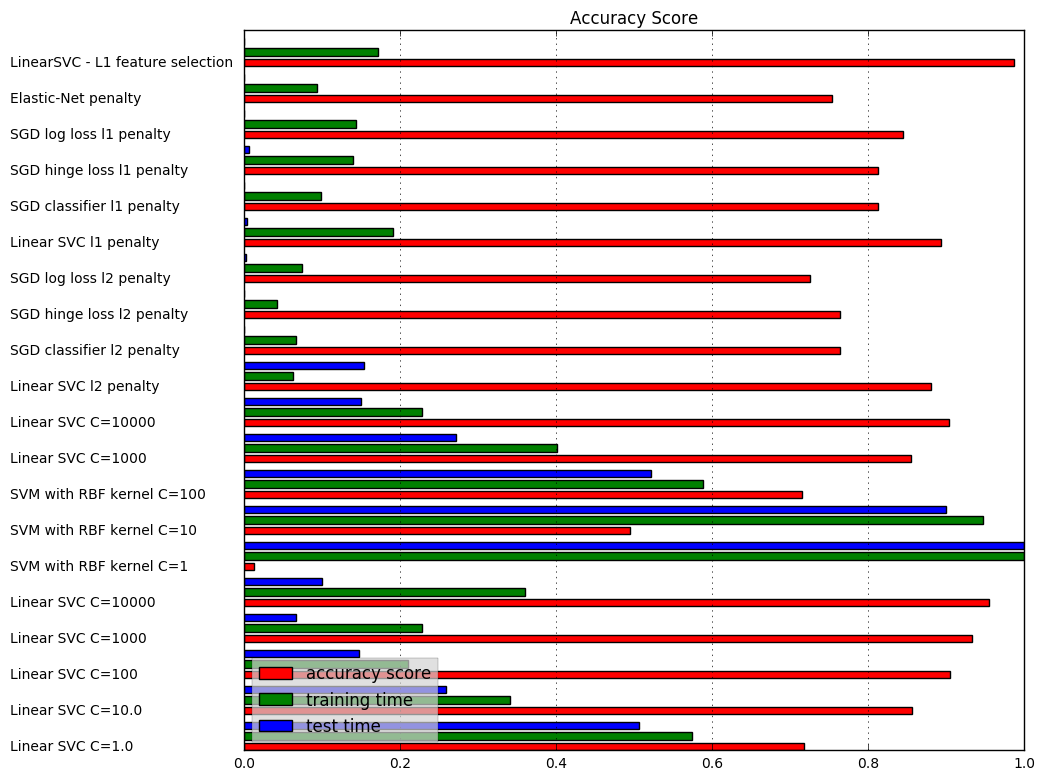

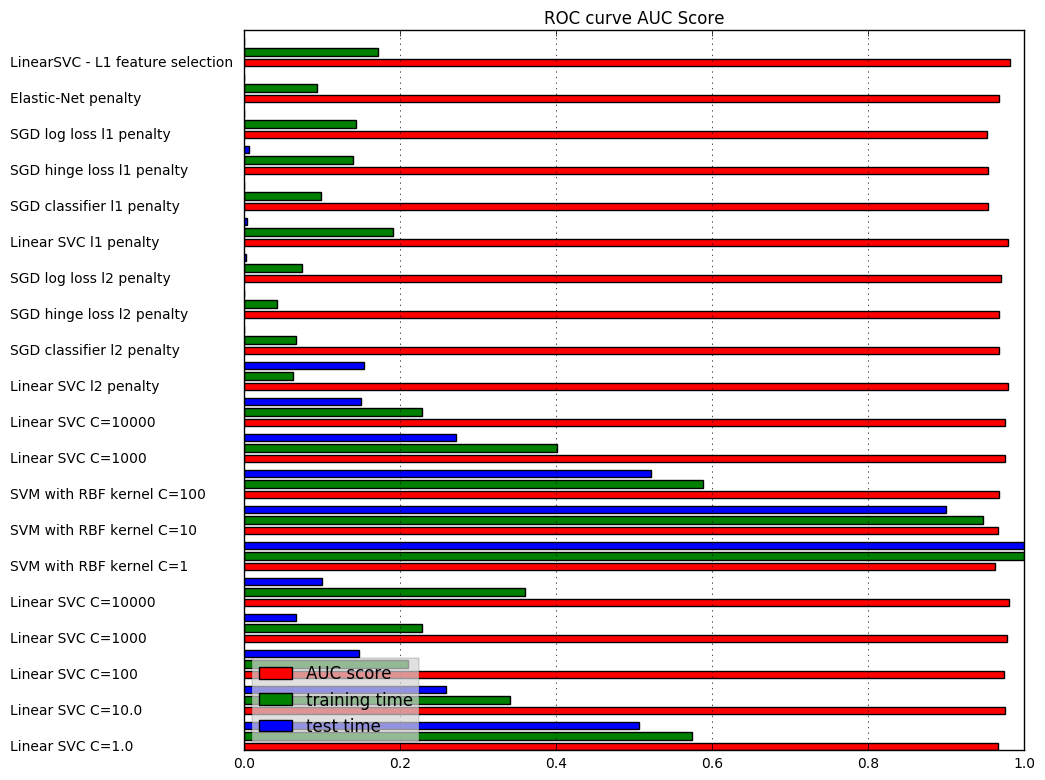

In [13]:
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [15]:
# Function to compute ROC curve and ROC area for each class
# based on the example in SciKitLearn
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_ROC_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the ROC curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=sw_test)
    roc_auc = auc(fpr, tpr)
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.3f})' .format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

# Compute Precision-Recall and plot curve
# As above, based on the SciKit Learn example

def plot_PR_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the precision recall curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    
    precision = dict()
    recall = dict()
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1, sample_weight=sw_test)
    
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall, precision, label='Precision-recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

# Convenience function to adjust plot parameters for a clear layout.
target_names = ["Excluded", "Included"]

def show_confusion_matrix(cm):
    """
    cm - confusion matrix parameters as output from confusion_matrix() function
    
    yields: a plot of the confusion matrix with imshow
    Convenience function to adjust confusion matrix plot parameters for a clear layout.
    """
    sw_test = weight(y_test)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    """
    clf - classifier
    x_train - matrix of training features
    x_test - matrix of training features
    y_train - array of training labels
    y_test - array of validation truths
    yields: print outs of the full suite of metrics for the classification for both training and validation sets
    """
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)), '\n')
    scores1 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'accuracy' , n_jobs = 1)
    scores2 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='macro')
    acc_score = accuracy_score(y_train, y_pred)#, sample_weight=sw_test)
    cm = confusion_matrix(y_pred, y_train)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f\n" % 
          (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm)

    pred = clf.predict(x_test)

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)), '\n')
    report = precision_recall_fscore_support(y_test, pred, average='macro')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm))
    show_confusion_matrix(cm)

In [16]:
#RANDOM_STATE = 55


def run_class(X, y, TEST_SIZE):
    """
    X - input matrix of features for the classification
    y - array of truths for the classification 
    TEST_SIZE - number or proportion to use for the test set - int is number, float is precentage
    
    yields: this version runs a battery of classifiers. For each of them, it  
    prints out the performance metrics for the classification and plots the ROC and PR curves
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)    
    
    sw_test = weight(y_test)
    
    for clf, name in (
            (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced'), "Perceptron50"),
            (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced', penalty = 'l1'), "Perceptron50l1"),
            (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced', penalty="l2"), "Perceptron50l2"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced'), "Perceptron20"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced', penalty = 'l1'), "Perceptron20l1"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced', penalty="l2"), "Perceptron20l2"),
            (linear_model.LogisticRegression(C=1e2, random_state=RANDOM_STATE, class_weight='balanced'), "Logistic Regression 1e2"),
            (linear_model.LogisticRegression(C=1e6, random_state=RANDOM_STATE, class_weight='balanced'), "Logistic Regression 1e6"),
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=100.0"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000.0"),
            (LinearSVC(penalty="l2", random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC L2 penalty"), 
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (MLPClassifier(hidden_layer_sizes=(5, 5), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(10, 10), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(5, 5), learning_rate='invscaling', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            ):
        
        print("\n", name, "\ntest size is %d %%  " % (TEST_SIZE*100))

        clf.fit(X_train, y_train)
        print (clf.score(X_test, y_test))
        
        mean_acc_score = clf.score(X_test, y_test)
        pred = clf.predict(X_test)

        report = precision_recall_fscore_support(y_test, pred, average='binary', sample_weight=sw_test)
        acc_score = accuracy_score(y_test, pred)
        cm = confusion_matrix(pred, y_test)

        # get the decision boundary or the probas.
        if hasattr(clf, "decision_function"):
            y_score = np.array(clf.decision_function(X_test))
        else:
            y_score = clf.predict_proba(X_test)[:,1]

        auc_score = metrics.roc_auc_score(y_test, y_score, sample_weight=sw_test)

        #print("mean_accuracy = %0.3f" % mean_acc_score)
        print("precision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f" % 
              (report[0], report[1], report[2], acc_score))
        print("The confusion matrix on the testing set:          \n", pd.DataFrame(cm))
        print("*********** AUC for ROC = %0.3f" % auc_score)
                
        plot_ROC_curve(y_test, y_score)
        plot_PR_curve(y_test, y_score)
        #print (y_score[:,:30])

('\n', 'Perceptron50', '\ntest size is 30 %  ')
0.921333333333
precision = 0.383, recall = 0.900, F1 = 0.537, accuracy = 0.921
('The confusion matrix on the testing set:          \n',      0  1
0  682  1
1   58  9)
*********** AUC for ROC = 0.975


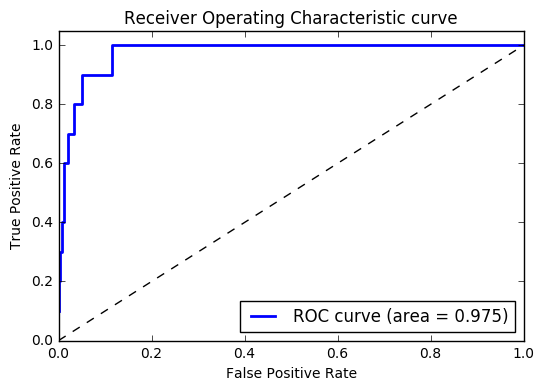

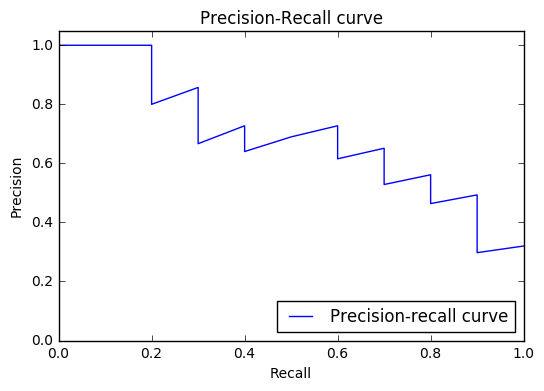

('\n', 'Perceptron50l1', '\ntest size is 30 %  ')
0.92
precision = 0.379, recall = 0.900, F1 = 0.533, accuracy = 0.920
('The confusion matrix on the testing set:          \n',      0  1
0  681  1
1   59  9)
*********** AUC for ROC = 0.972


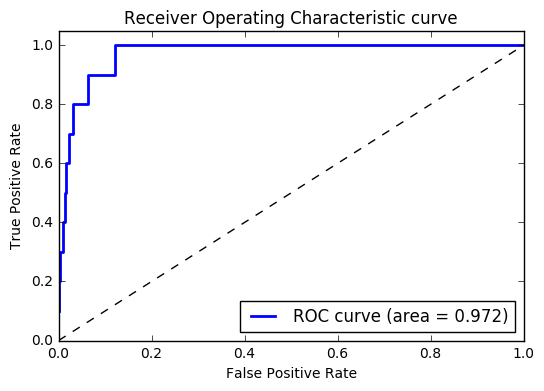

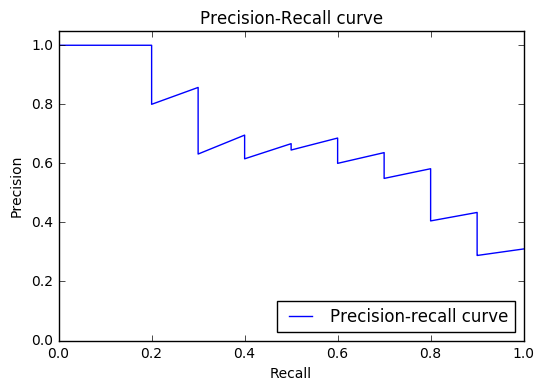

('\n', 'Perceptron50l2', '\ntest size is 30 %  ')
0.806666666667
precision = 0.216, recall = 1.000, F1 = 0.356, accuracy = 0.807
('The confusion matrix on the testing set:          \n',      0   1
0  595   0
1  145  10)
*********** AUC for ROC = 0.967


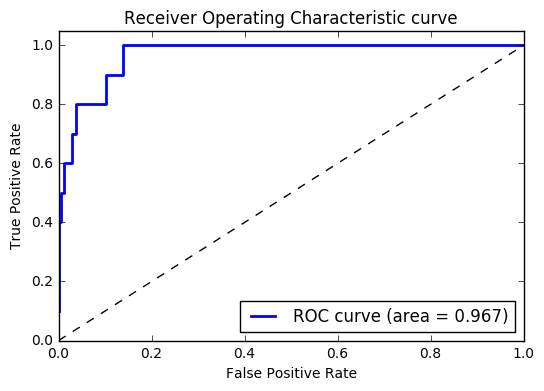

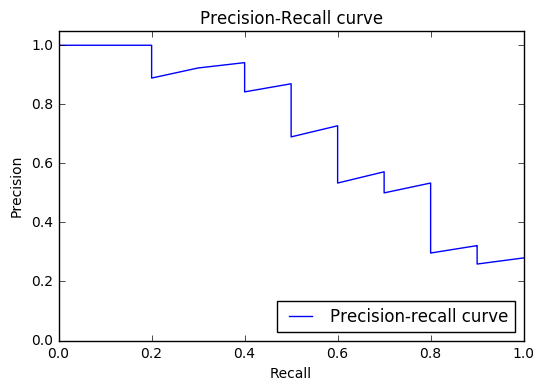

('\n', 'Perceptron20', '\ntest size is 30 %  ')
0.432
precision = 0.086, recall = 1.000, F1 = 0.158, accuracy = 0.432
('The confusion matrix on the testing set:          \n',      0   1
0  314   0
1  426  10)
*********** AUC for ROC = 0.966


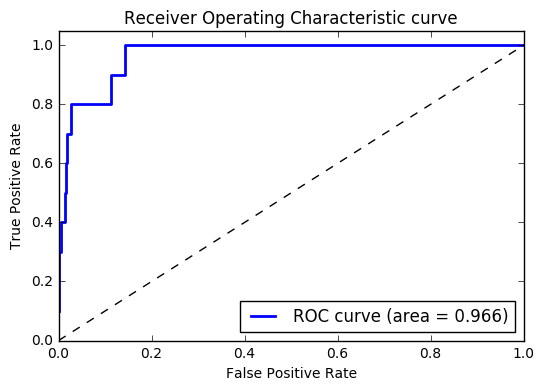

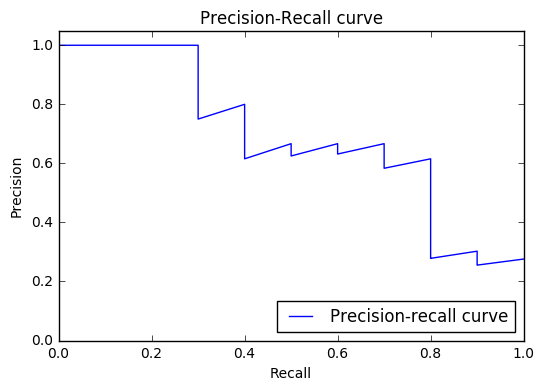

('\n', 'Perceptron20l1', '\ntest size is 30 %  ')
0.412
precision = 0.083, recall = 1.000, F1 = 0.154, accuracy = 0.412
('The confusion matrix on the testing set:          \n',      0   1
0  299   0
1  441  10)
*********** AUC for ROC = 0.969


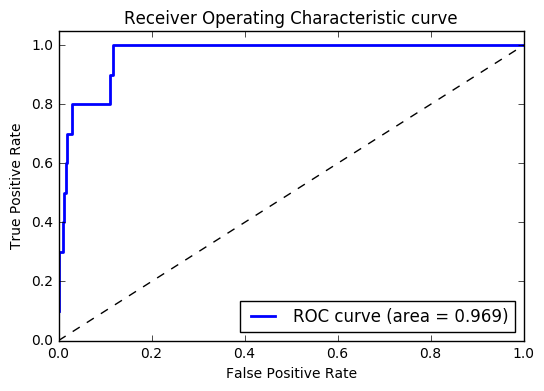

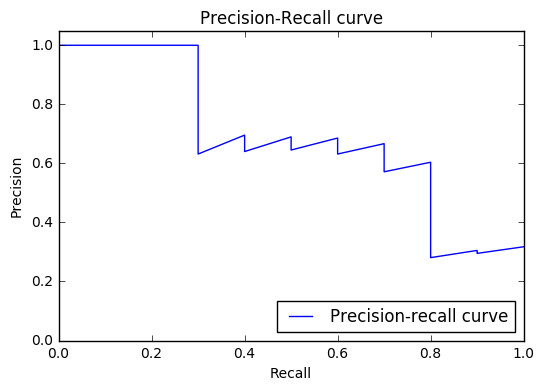

('\n', 'Perceptron20l2', '\ntest size is 30 %  ')
0.213333333333
precision = 0.063, recall = 1.000, F1 = 0.119, accuracy = 0.213
('The confusion matrix on the testing set:          \n',      0   1
0  150   0
1  590  10)
*********** AUC for ROC = 0.963


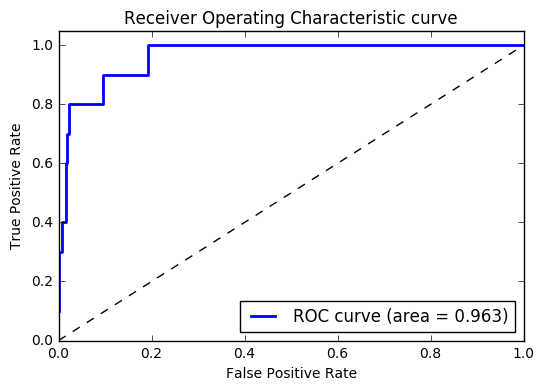

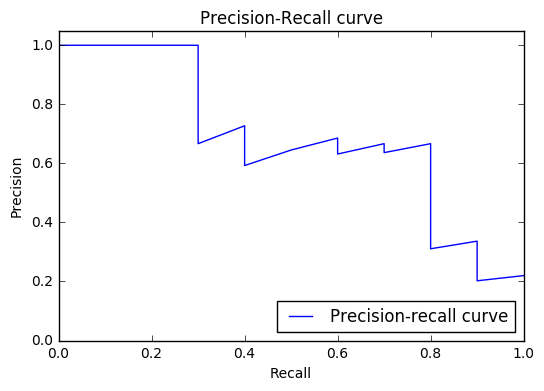

('\n', 'Logistic Regression 1e2', '\ntest size is 30 %  ')
0.910666666667
precision = 0.374, recall = 1.000, F1 = 0.544, accuracy = 0.911
('The confusion matrix on the testing set:          \n',      0   1
0  673   0
1   67  10)
*********** AUC for ROC = 0.980


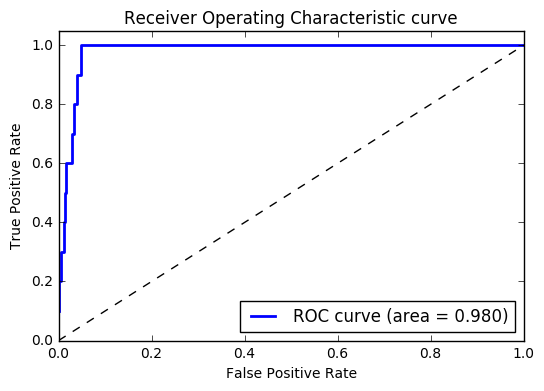

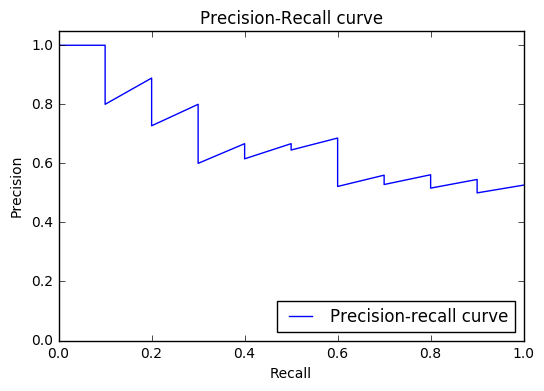

('\n', 'Logistic Regression 1e6', '\ntest size is 30 %  ')
0.966666666667
precision = 0.582, recall = 0.800, F1 = 0.674, accuracy = 0.967
('The confusion matrix on the testing set:          \n',      0  1
0  717  2
1   23  8)
*********** AUC for ROC = 0.979


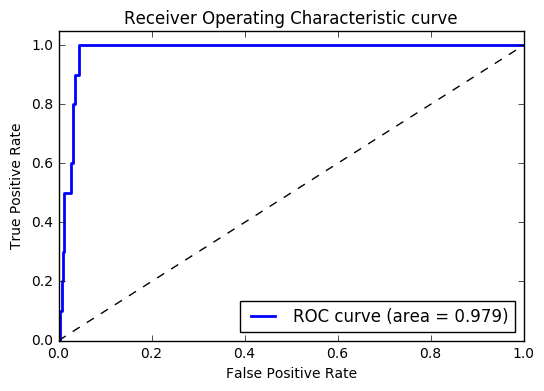

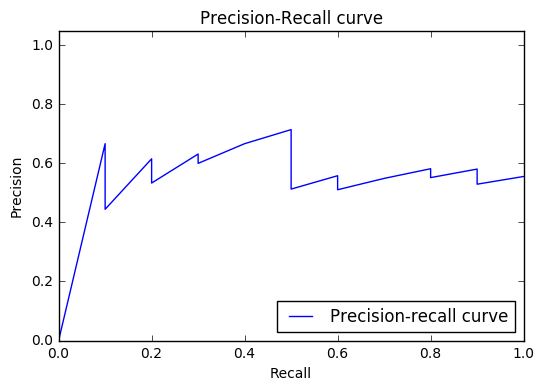

('\n', 'Linear SVC C=1.0', '\ntest size is 30 %  ')
0.853333333333
precision = 0.267, recall = 1.000, F1 = 0.421, accuracy = 0.853
('The confusion matrix on the testing set:          \n',      0   1
0  630   0
1  110  10)
*********** AUC for ROC = 0.973


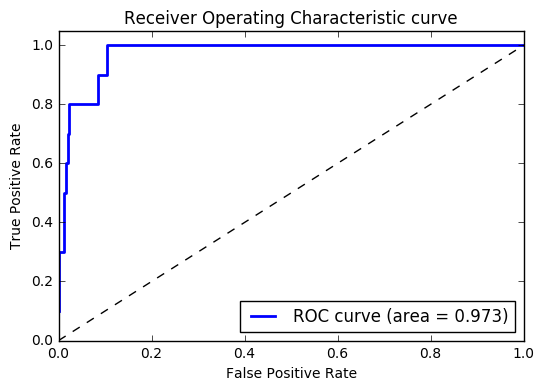

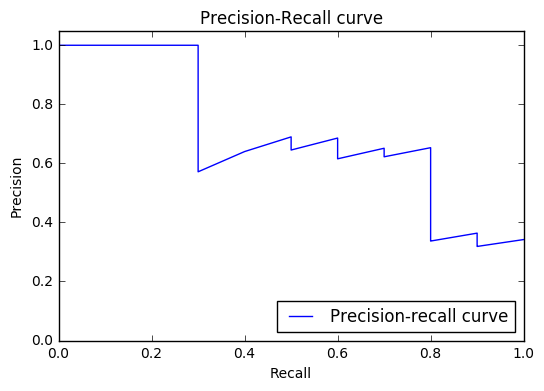

('\n', 'Linear SVC C=10.0', '\ntest size is 30 %  ')
0.889333333333
precision = 0.325, recall = 1.000, F1 = 0.491, accuracy = 0.889
('The confusion matrix on the testing set:          \n',      0   1
0  657   0
1   83  10)
*********** AUC for ROC = 0.981


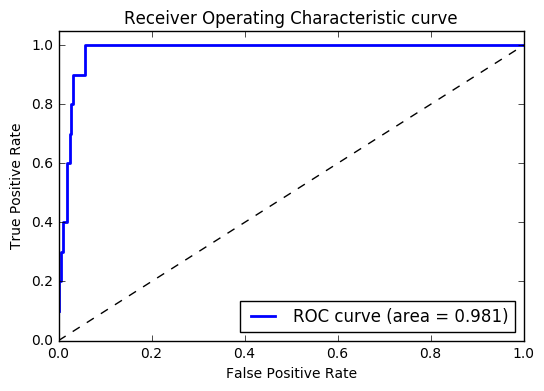

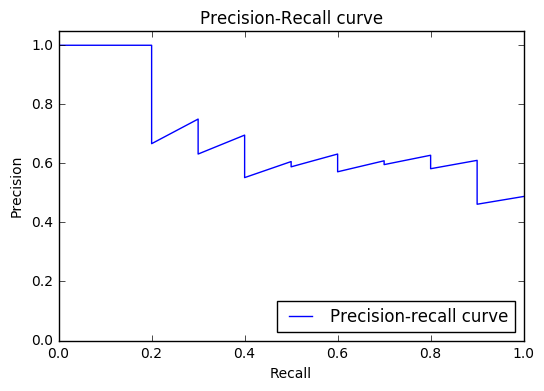

('\n', 'Linear SVC C=100.0', '\ntest size is 30 %  ')
0.905333333333
precision = 0.360, recall = 1.000, F1 = 0.530, accuracy = 0.905
('The confusion matrix on the testing set:          \n',      0   1
0  669   0
1   71  10)
*********** AUC for ROC = 0.974


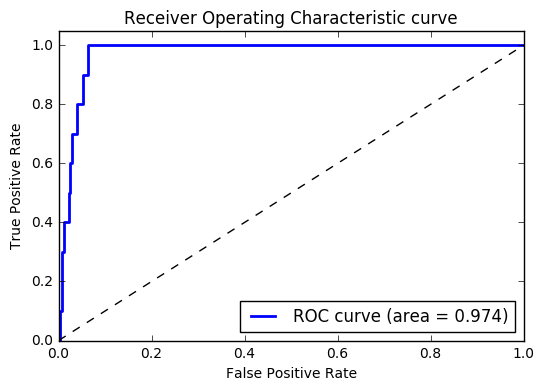

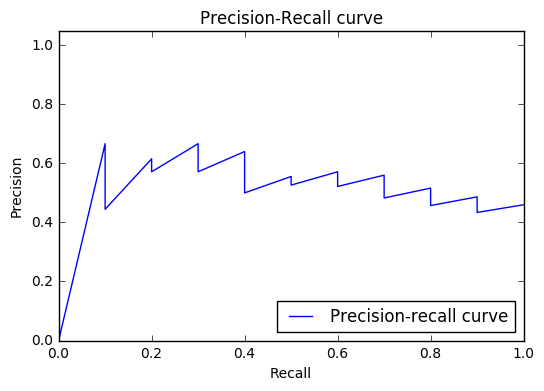

('\n', 'Linear SVC C=1000.0', '\ntest size is 30 %  ')
0.933333333333
precision = 0.444, recall = 1.000, F1 = 0.615, accuracy = 0.933
('The confusion matrix on the testing set:          \n',      0   1
0  690   0
1   50  10)
*********** AUC for ROC = 0.978


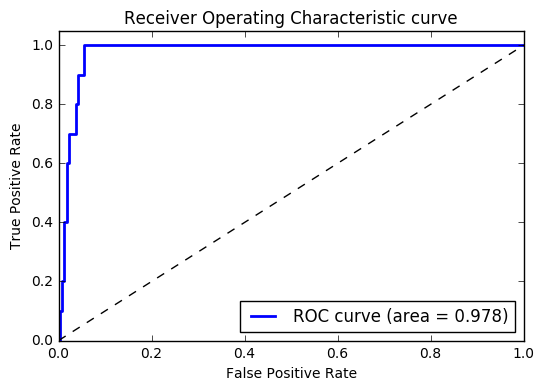

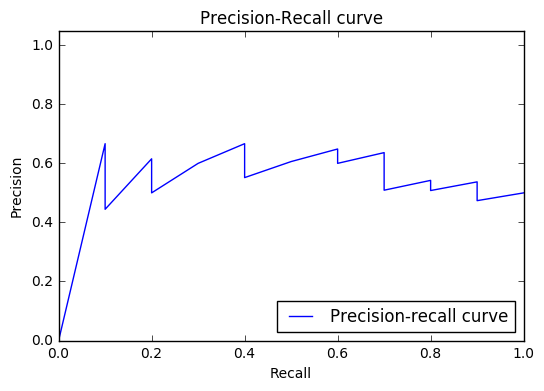

('\n', 'Linear SVC L2 penalty', '\ntest size is 30 %  ')
0.881333333333
precision = 0.310, recall = 1.000, F1 = 0.473, accuracy = 0.881
('The confusion matrix on the testing set:          \n',      0   1
0  651   0
1   89  10)
*********** AUC for ROC = 0.979


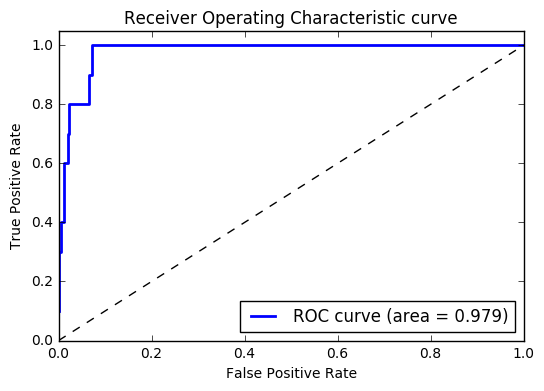

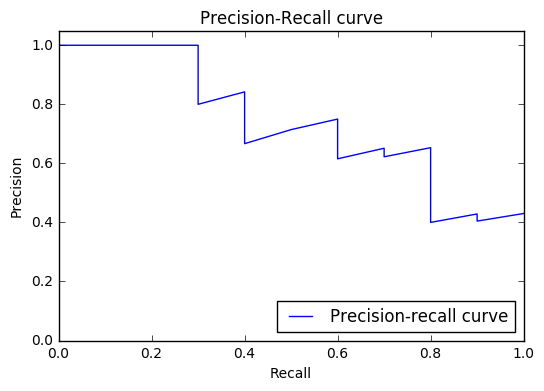

('\n', 'SVM with RBF kernel C=1', '\ntest size is 30 %  ')
0.0146666666667
precision = 0.051, recall = 1.000, F1 = 0.098, accuracy = 0.015
('The confusion matrix on the testing set:          \n',      0   1
0    1   0
1  739  10)
*********** AUC for ROC = 0.961


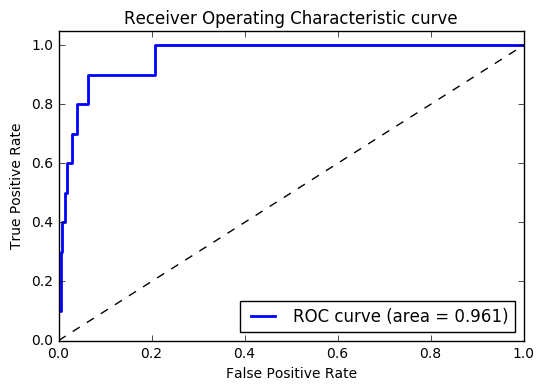

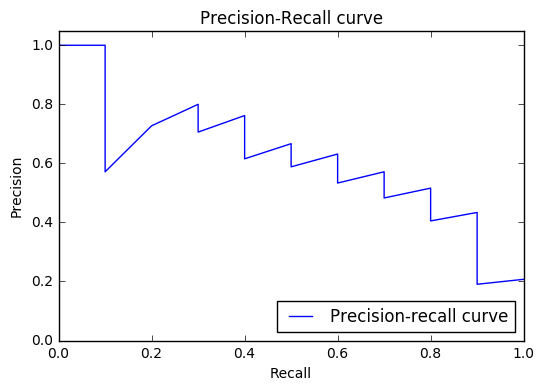

('\n', 'SVM with RBF kernel C=10', '\ntest size is 30 %  ')
0.784
precision = 0.198, recall = 1.000, F1 = 0.331, accuracy = 0.784
('The confusion matrix on the testing set:          \n',      0   1
0  578   0
1  162  10)
*********** AUC for ROC = 0.966


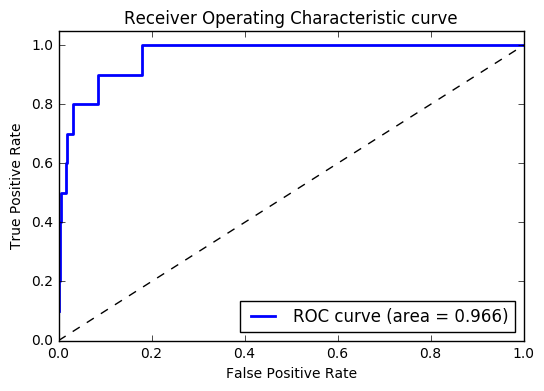

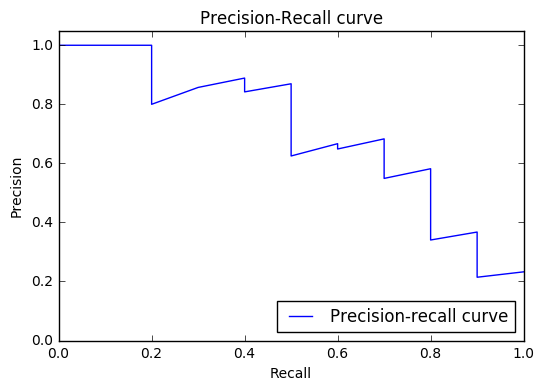

('\n', 'SVM with RBF kernel C=100', '\ntest size is 30 %  ')
0.849333333333
precision = 0.261, recall = 1.000, F1 = 0.415, accuracy = 0.849
('The confusion matrix on the testing set:          \n',      0   1
0  627   0
1  113  10)
*********** AUC for ROC = 0.973


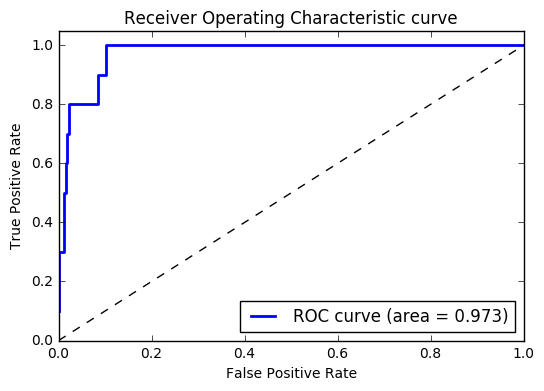

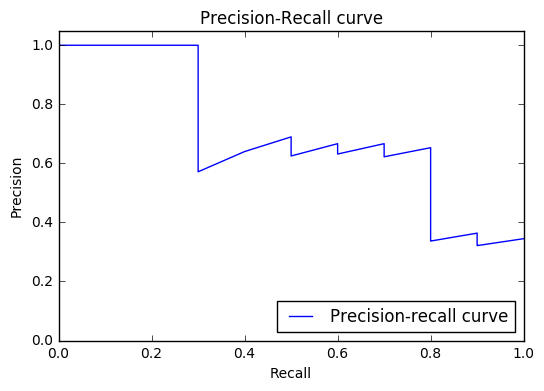

('\n', 'SVM with RBF kernel C=1000', '\ntest size is 30 %  ')
0.888
precision = 0.323, recall = 1.000, F1 = 0.488, accuracy = 0.888
('The confusion matrix on the testing set:          \n',      0   1
0  656   0
1   84  10)
*********** AUC for ROC = 0.981


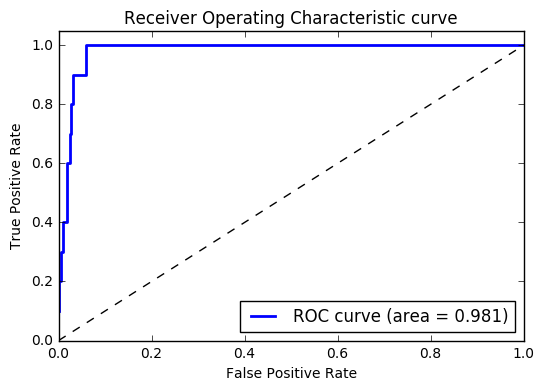

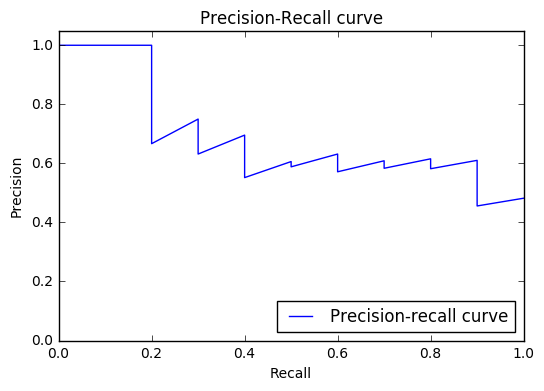

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.986666666667
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.987
('The confusion matrix on the testing set:          \n',      0   1
0  740  10
1    0   0)
*********** AUC for ROC = 0.971


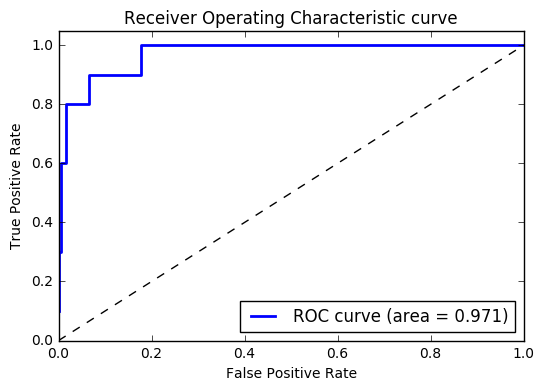

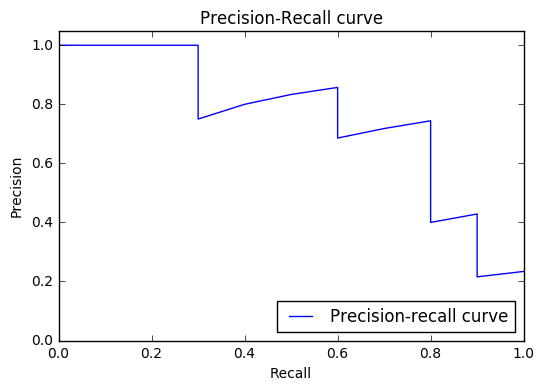

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.986666666667
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.987
('The confusion matrix on the testing set:          \n',      0   1
0  740  10
1    0   0)
*********** AUC for ROC = 0.971


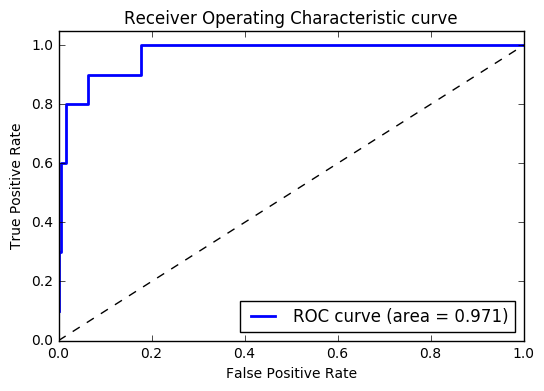

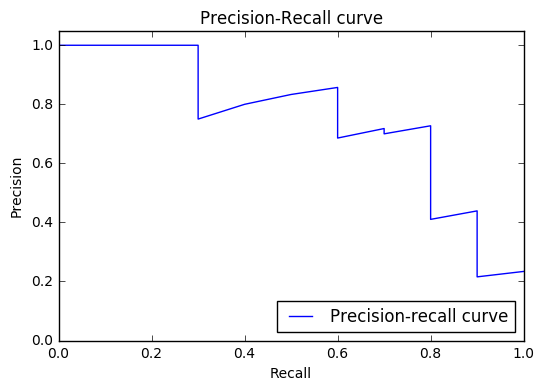

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.986666666667
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.987
('The confusion matrix on the testing set:          \n',      0   1
0  740  10
1    0   0)
*********** AUC for ROC = 0.971


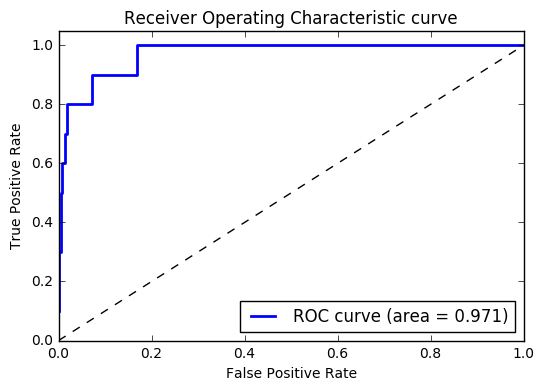

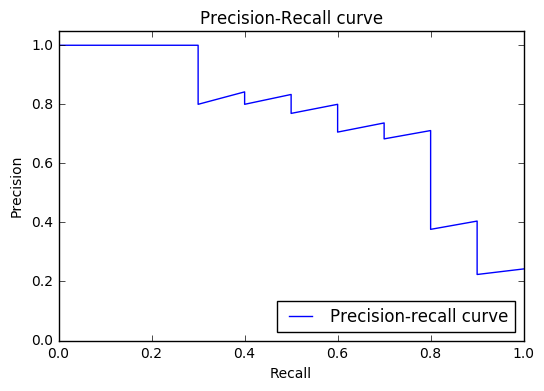

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.986666666667
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.987
('The confusion matrix on the testing set:          \n',      0   1
0  740  10
1    0   0)
*********** AUC for ROC = 0.971


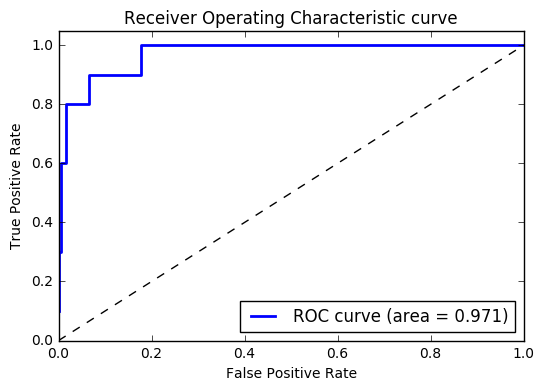

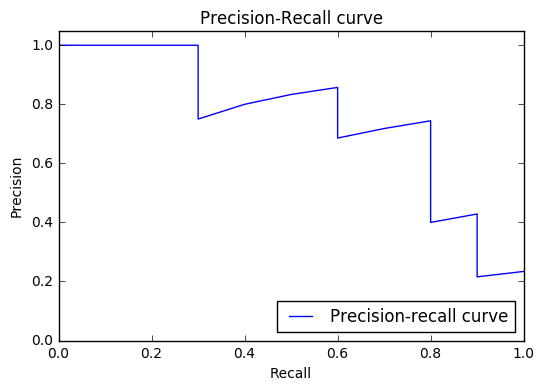

In [17]:
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [18]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'class_weight':['balanced', None],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight':['balanced', None]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'kernel': 'linear', 'C': 1000, 'class_weight': 'balanced'}
()
Grid scores on development set:
()
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': 'balanced'}
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': None}
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': None}
0.258 (+/-0.500) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': 'balanced'}
0.008 (+/-0.001) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': None}
0.492 (+/-0.001) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': None}
0.538 (+/-0.020) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500

In [19]:
# Set the parameters by cross-validation
#PERCEPTRON
tuned_parameters = [{'n_iter': [2, 5, 10,50],
                     'penalty': [None, 'l2', 'l1', 'elasticnet'],
                     'alpha': [0.001, 0.0001, 0.00001],
                     'class_weight':['balanced', None]
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(Perceptron(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'penalty': 'l2', 'alpha': 0.0001, 'n_iter': 50, 'class_weight': None}
()
Grid scores on development set:
()
0.582 (+/-0.077) for {'penalty': None, 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.528 (+/-0.038) for {'penalty': 'l2', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.524 (+/-0.029) for {'penalty': 'l1', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.528 (+/-0.038) for {'penalty': 'elasticnet', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.547 (+/-0.003) for {'penalty': None, 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.250 (+/-0.483) for {'penalty': 'l2', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.549 (+/-0.042) for {'penalty': 'l1', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.250 (+/-0.483) for {'penalty': 'elasticnet', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.546 (+/-0.006

In [20]:
# Set the parameters by cross-validation
#linearsvc


tuned_parameters = [{'C': [1.0, 10, 100, 1000],
                     #'penalty': ['l2', 'l1'],
                     'class_weight':['balanced', None],
                     #'loss': ['squared_hinge', 'hinge'],
                     #'dual': [True, False],
                     'multi_class': ['crammer_singer', 'ovr']
                     }]

                    
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'multi_class': 'ovr', 'C': 1000, 'class_weight': None}
()
Grid scores on development set:
()
0.546 (+/-0.021) for {'multi_class': 'crammer_singer', 'C': 1.0, 'class_weight': 'balanced'}
0.548 (+/-0.008) for {'multi_class': 'ovr', 'C': 1.0, 'class_weight': 'balanced'}
0.492 (+/-0.001) for {'multi_class': 'crammer_singer', 'C': 1.0, 'class_weight': None}
0.492 (+/-0.001) for {'multi_class': 'ovr', 'C': 1.0, 'class_weight': None}
0.549 (+/-0.005) for {'multi_class': 'crammer_singer', 'C': 10, 'class_weight': 'balanced'}
0.559 (+/-0.021) for {'multi_class': 'ovr', 'C': 10, 'class_weight': 'balanced'}
0.492 (+/-0.001) for {'multi_class': 'crammer_singer', 'C': 10, 'class_weight': None}
0.492 (+/-0.001) for {'multi_class': 'ovr', 'C': 10, 'class_weight': None}
0.572 (+/-0.014) for {'multi_class': 'crammer_singer', 'C': 100, 'class_weight': 'balanced'}
0.597 (+/-0.057) for {'multi_class': 'ovr', 'C': 

In [21]:
# Set the parameters by cross-validation
#MLP

tuned_parameters = [{'hidden_layer_sizes': [(5,5), (10,10), (20,10)],
                     'learning_rate': ['invscaling', 'adaptive', 'constant'],
                     'learning_rate_init': [0.001, 0.0001, 0.00001],
                     #'class_weight':['balanced', None],
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'solver':['lbfgs', 'sgd', 'adam']
                    }]
 
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(MLPClassifier(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'activation': 'tanh', 'solver': 'lbfgs', 'learning_rate': 'constant', 'learning_rate_init': 1e-05, 'hidden_layer_sizes': (20, 10)}
()
Grid scores on development set:
()
0.622 (+/-0.006) for {'activation': 'identity', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.260 (+/-0.503) for {'activation': 'identity', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.492 (+/-0.001) for {'activation': 'identity', 'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.626 (+/-0.029) for {'activation': 'identity', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (5, 5)}
0.250 (+/-0.483) for {'activation': 'identity', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_i

In [22]:
# Set the parameters by cross-validation
#MLP
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

tuned_parameters = [{'hidden_layer_sizes': [(5,5), (10,10), (20,10)],
                     'learning_rate': ['invscaling', 'adaptive', 'constant'],
                     'learning_rate_init': [0.001, 0.0001, 0.00001],
                    # 'class_weight':['balanced', None],
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'solver':['lbfgs', 'sgd', 'adam']
                    }]

                    
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(MLPClassifier(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (20, 10)}
()
Grid scores on development set:
()
0.627 (+/-0.013) for {'activation': 'identity', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.494 (+/-0.014) for {'activation': 'identity', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.492 (+/-0.001) for {'activation': 'identity', 'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (5, 5)}
0.609 (+/-0.007) for {'activation': 'identity', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (5, 5)}
0.503 (+/-0.010) for {'activation': 'identity', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_

Linear SVC C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=61, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.296s
test time:  0.107s
accuracy:   0.856
precision:  0.122
recall:     1.000
('Complexity: ', array([700,  12]))
*** AUC for ROC = 0.969

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.85      0.92       735
   Relevant       0.12      1.00      0.22        15

avg / total       0.98      0.86      0.91       750

confusion matrix:
[[627 108]
 [  0  15]]
()
Linear SVC C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='au

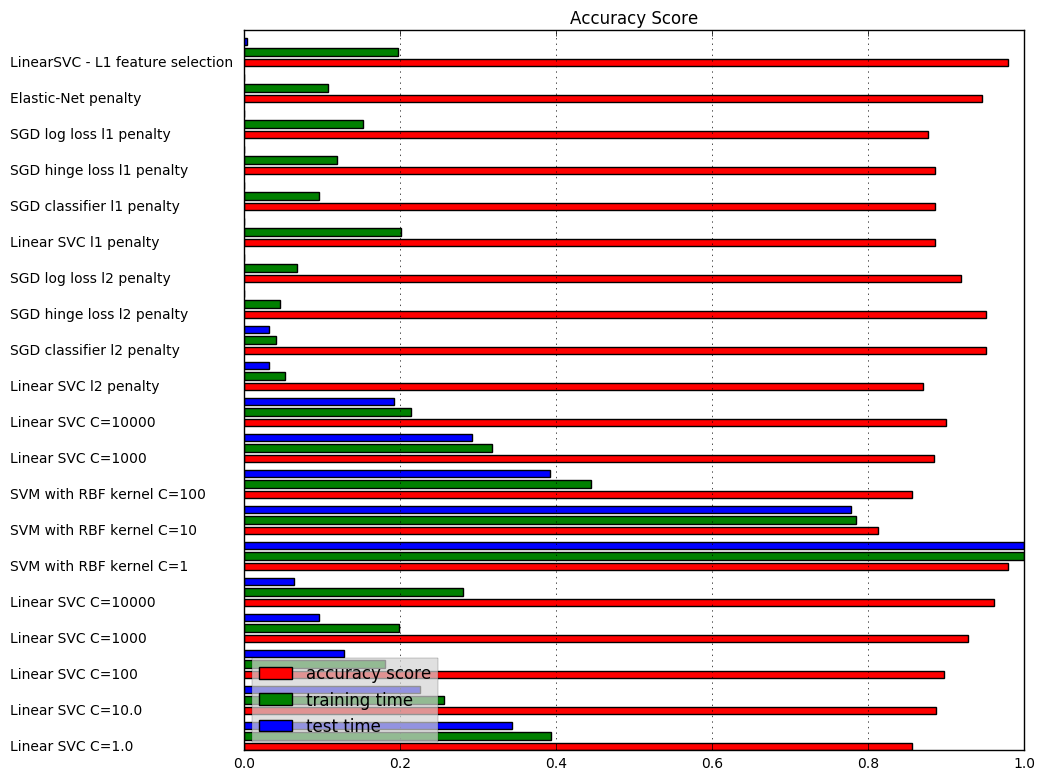

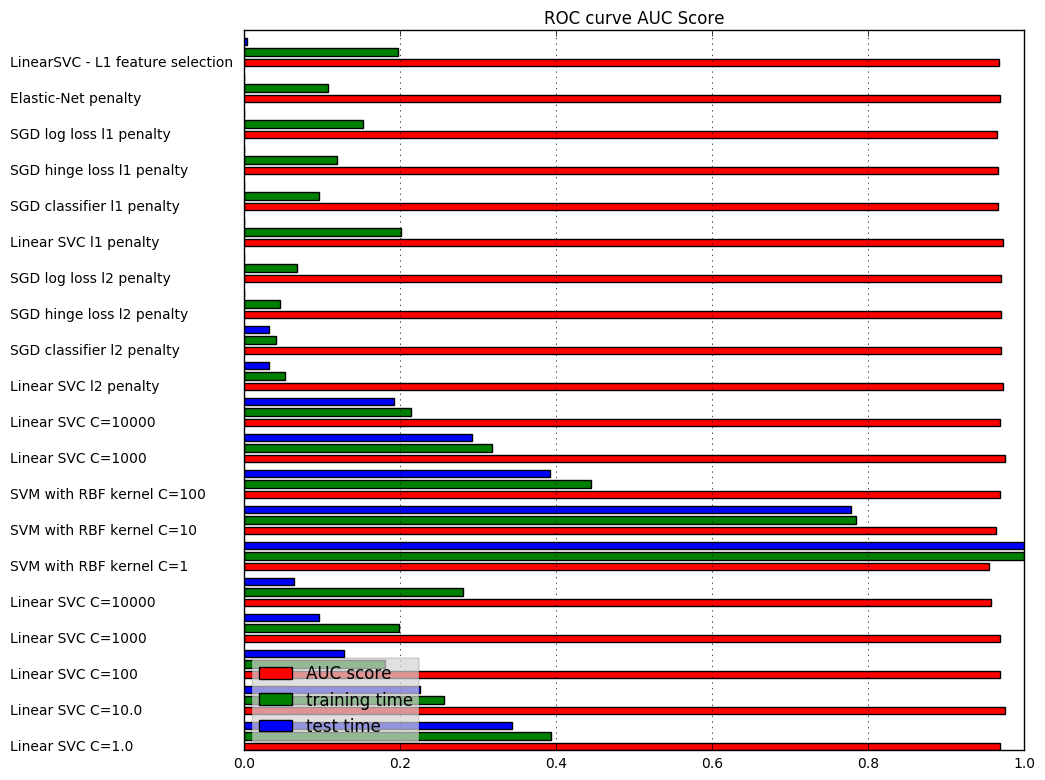

('\n', 'Perceptron50', '\ntest size is 30 %  ')
0.942666666667
precision = 0.530, recall = 0.733, F1 = 0.615, accuracy = 0.943
('The confusion matrix on the testing set:          \n',      0   1
0  696   4
1   39  11)
*********** AUC for ROC = 0.967


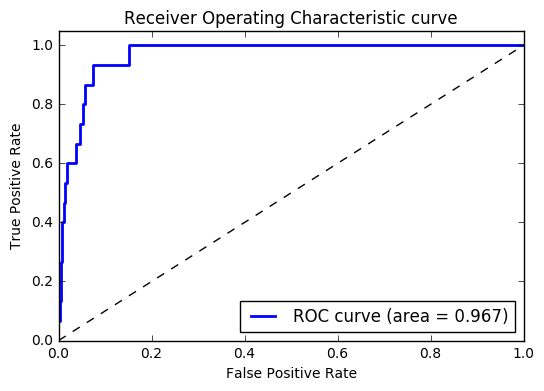

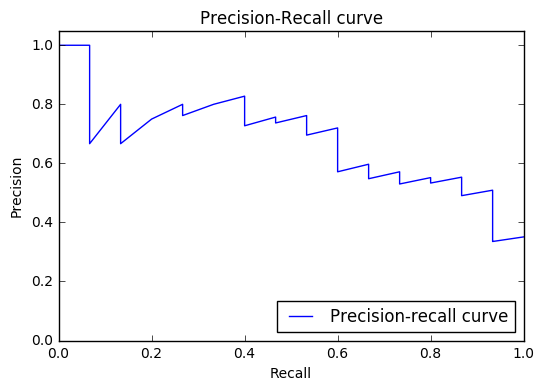

('\n', 'Perceptron50l1', '\ntest size is 30 %  ')
0.944
precision = 0.519, recall = 0.667, F1 = 0.584, accuracy = 0.944
('The confusion matrix on the testing set:          \n',      0   1
0  698   5
1   37  10)
*********** AUC for ROC = 0.968


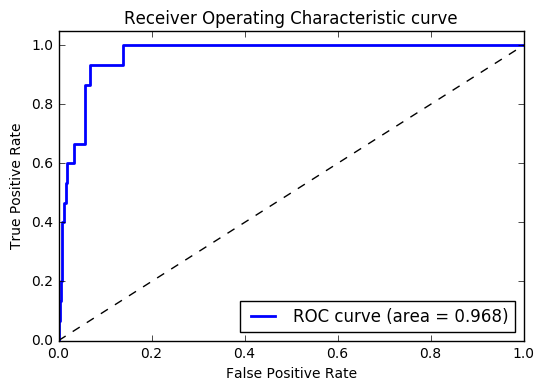

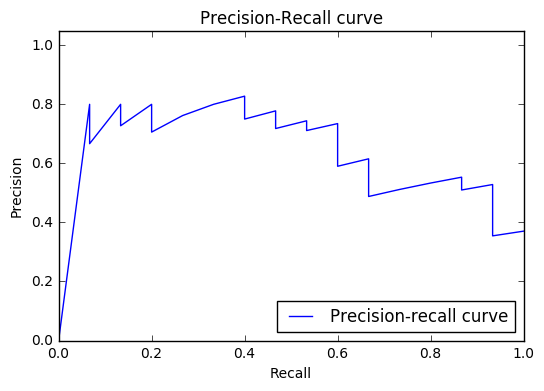

('\n', 'Perceptron50l2', '\ntest size is 30 %  ')
0.868
precision = 0.364, recall = 0.933, F1 = 0.523, accuracy = 0.868
('The confusion matrix on the testing set:          \n',      0   1
0  637   1
1   98  14)
*********** AUC for ROC = 0.963


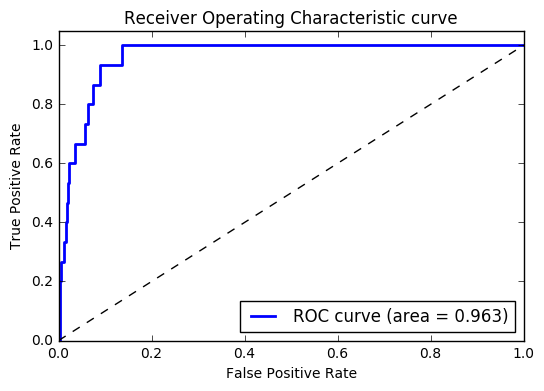

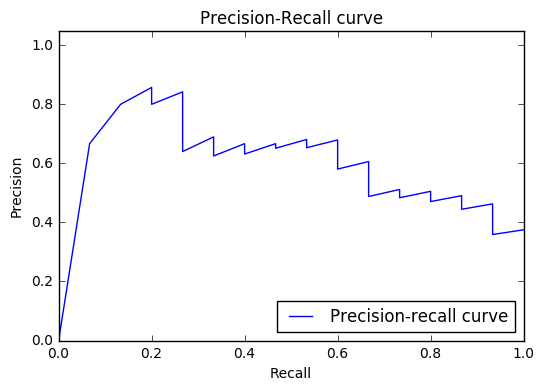

('\n', 'Perceptron20', '\ntest size is 30 %  ')
0.52
precision = 0.143, recall = 1.000, F1 = 0.250, accuracy = 0.520
('The confusion matrix on the testing set:          \n',      0   1
0  375   0
1  360  15)
*********** AUC for ROC = 0.968


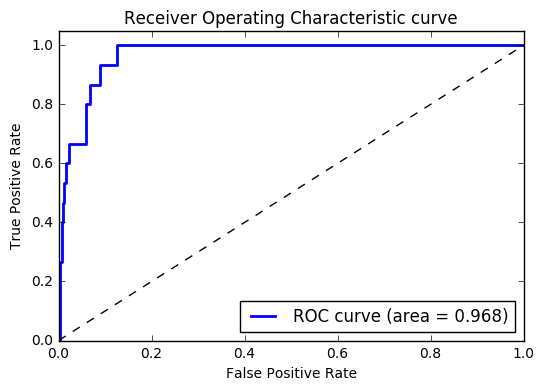

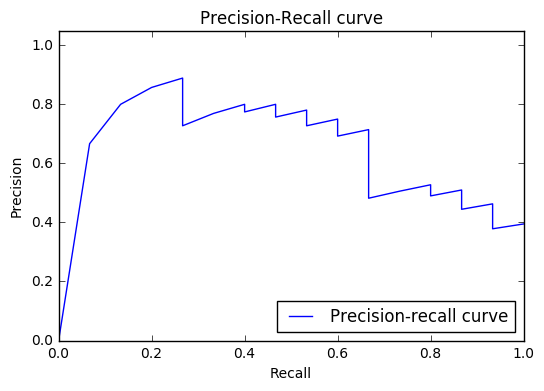

('\n', 'Perceptron20l1', '\ntest size is 30 %  ')
0.516
precision = 0.142, recall = 1.000, F1 = 0.248, accuracy = 0.516
('The confusion matrix on the testing set:          \n',      0   1
0  372   0
1  363  15)
*********** AUC for ROC = 0.973


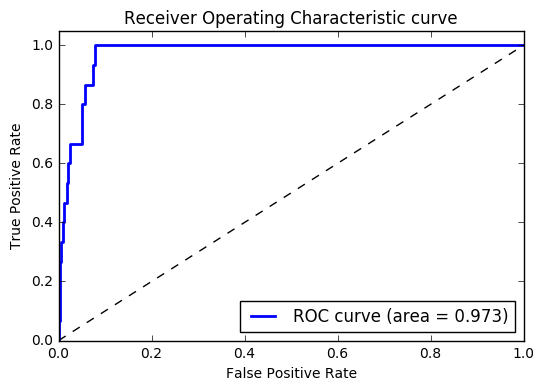

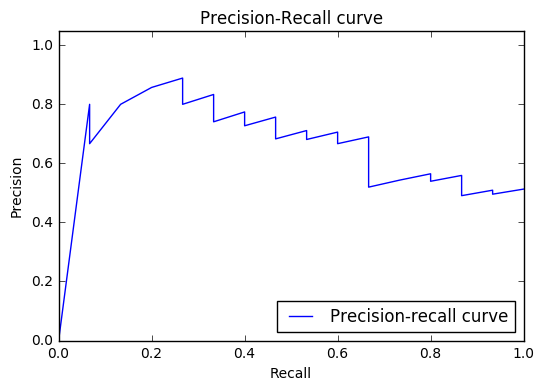

('\n', 'Perceptron20l2', '\ntest size is 30 %  ')
0.445333333333
precision = 0.126, recall = 1.000, F1 = 0.224, accuracy = 0.445
('The confusion matrix on the testing set:          \n',      0   1
0  319   0
1  416  15)
*********** AUC for ROC = 0.969


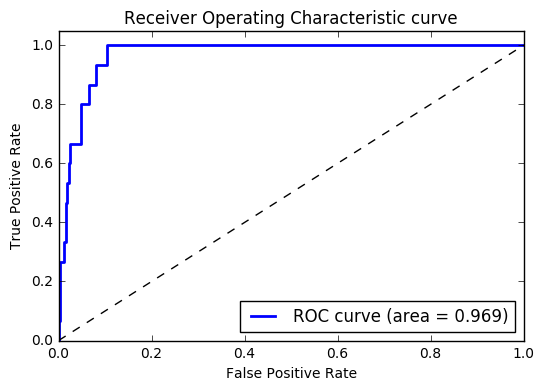

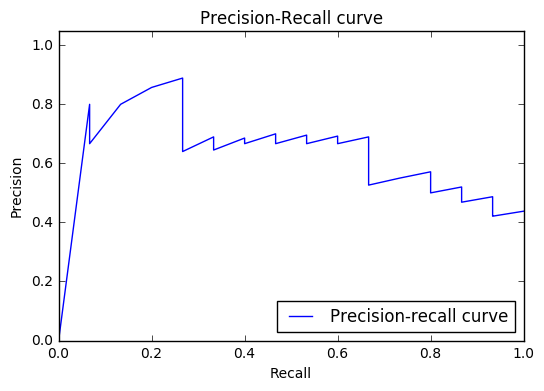

('\n', 'Logistic Regression 1e2', '\ntest size is 30 %  ')
0.894666666667
precision = 0.418, recall = 0.933, F1 = 0.577, accuracy = 0.895
('The confusion matrix on the testing set:          \n',      0   1
0  657   1
1   78  14)
*********** AUC for ROC = 0.973


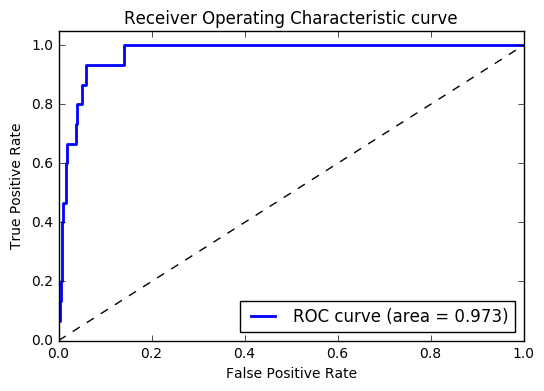

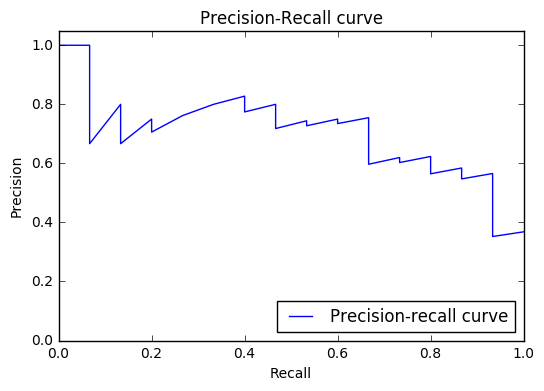

('\n', 'Logistic Regression 1e6', '\ntest size is 30 %  ')
0.973333333333
precision = 0.720, recall = 0.600, F1 = 0.655, accuracy = 0.973
('The confusion matrix on the testing set:          \n',      0  1
0  721  6
1   14  9)
*********** AUC for ROC = 0.957


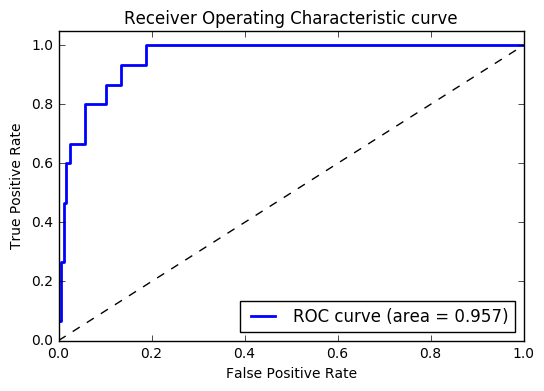

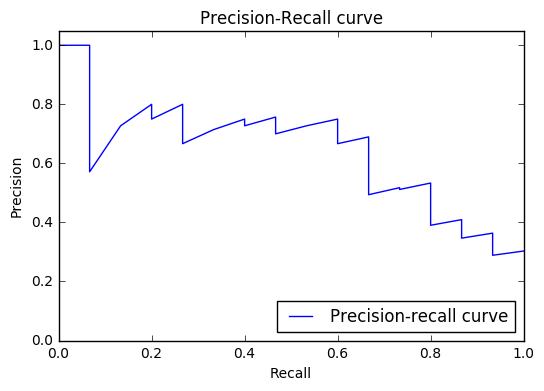

('\n', 'Linear SVC C=1.0', '\ntest size is 30 %  ')
0.848
precision = 0.345, recall = 1.000, F1 = 0.513, accuracy = 0.848
('The confusion matrix on the testing set:          \n',      0   1
0  621   0
1  114  15)
*********** AUC for ROC = 0.969


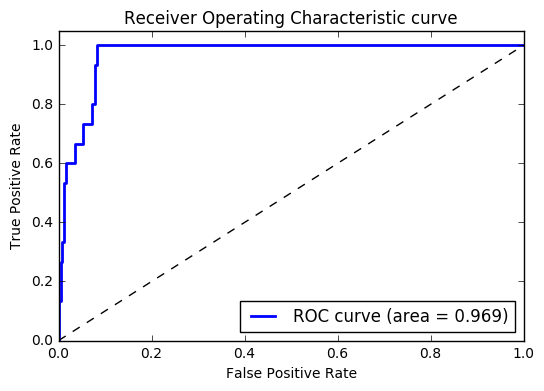

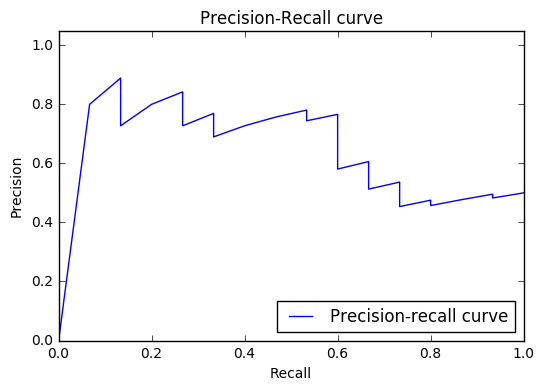

('\n', 'Linear SVC C=10.0', '\ntest size is 30 %  ')
0.878666666667
precision = 0.397, recall = 1.000, F1 = 0.569, accuracy = 0.879
('The confusion matrix on the testing set:          \n',      0   1
0  644   0
1   91  15)
*********** AUC for ROC = 0.975


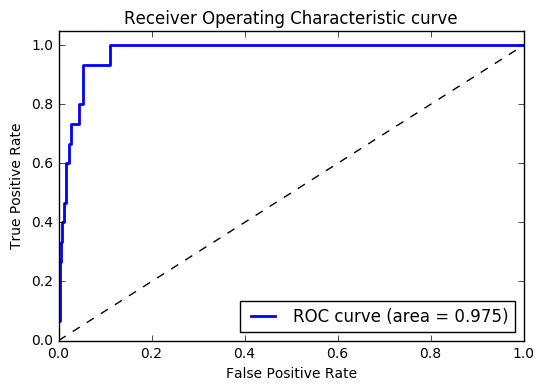

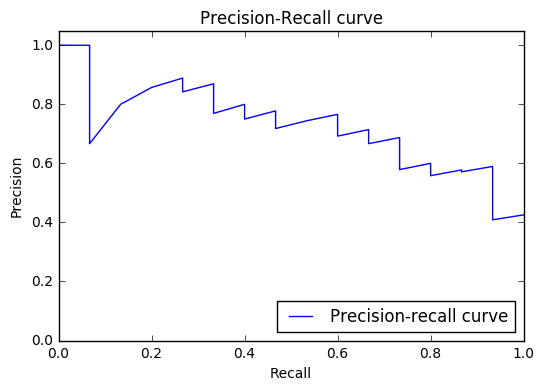

('\n', 'Linear SVC C=100.0', '\ntest size is 30 %  ')
0.9
precision = 0.431, recall = 0.933, F1 = 0.589, accuracy = 0.900
('The confusion matrix on the testing set:          \n',      0   1
0  661   1
1   74  14)
*********** AUC for ROC = 0.969


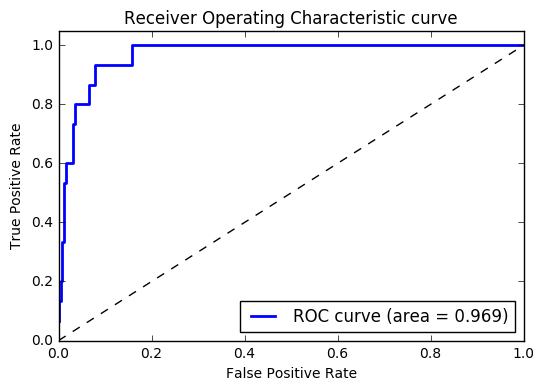

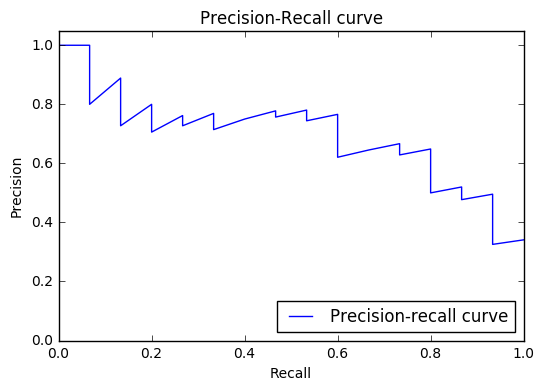

('\n', 'Linear SVC C=1000.0', '\ntest size is 30 %  ')
0.925333333333
precision = 0.475, recall = 0.800, F1 = 0.596, accuracy = 0.925
('The confusion matrix on the testing set:          \n',      0   1
0  682   3
1   53  12)
*********** AUC for ROC = 0.968


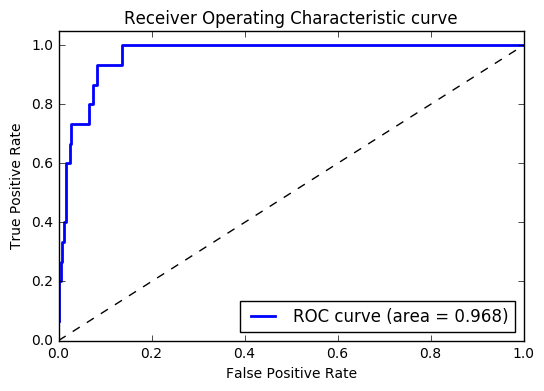

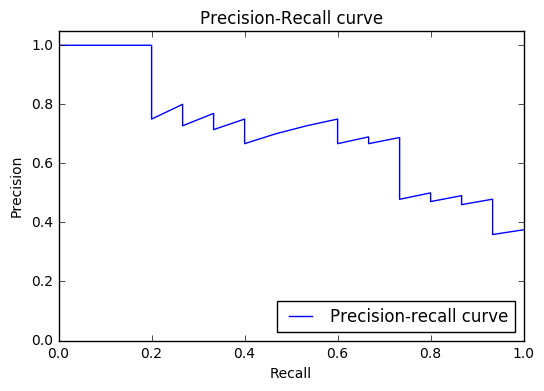

('\n', 'Linear SVC L2 penalty', '\ntest size is 30 %  ')
0.870666666667
precision = 0.382, recall = 1.000, F1 = 0.553, accuracy = 0.871
('The confusion matrix on the testing set:          \n',      0   1
0  638   0
1   97  15)
*********** AUC for ROC = 0.973


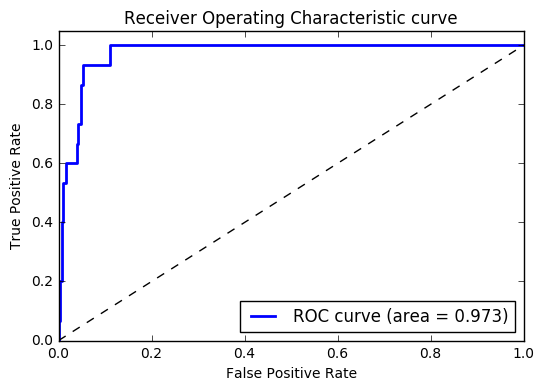

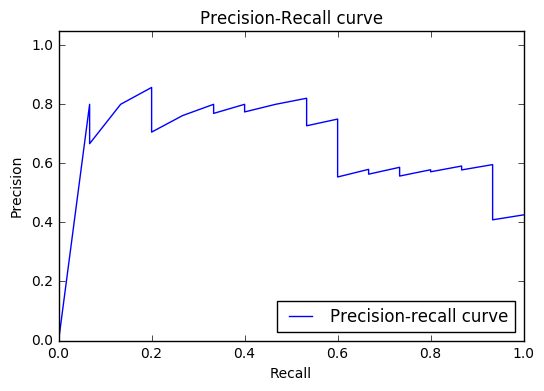

('\n', 'SVM with RBF kernel C=1', '\ntest size is 30 %  ')
0.0226666666667
precision = 0.076, recall = 1.000, F1 = 0.141, accuracy = 0.023
('The confusion matrix on the testing set:          \n',      0   1
0    2   0
1  733  15)
*********** AUC for ROC = 0.955


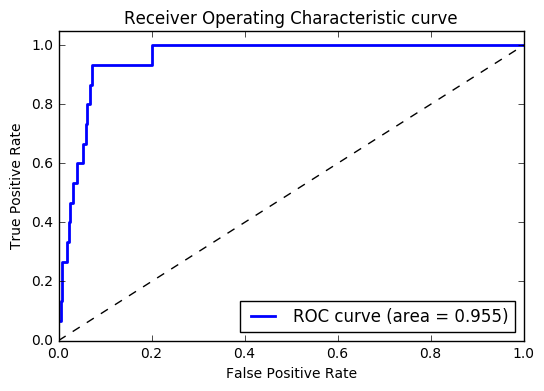

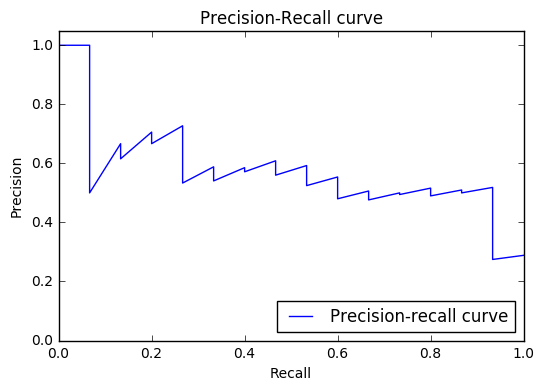

('\n', 'SVM with RBF kernel C=10', '\ntest size is 30 %  ')
0.808
precision = 0.294, recall = 1.000, F1 = 0.455, accuracy = 0.808
('The confusion matrix on the testing set:          \n',      0   1
0  591   0
1  144  15)
*********** AUC for ROC = 0.964


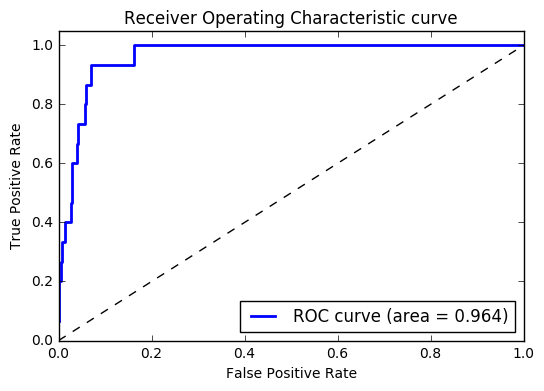

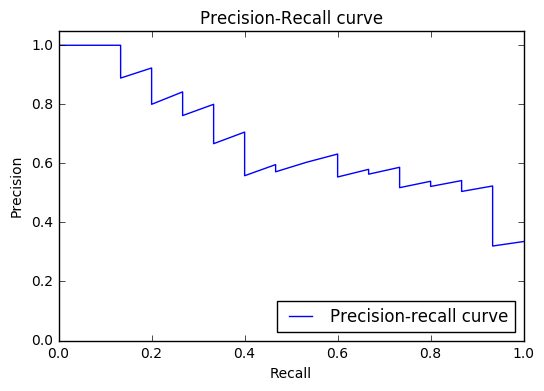

('\n', 'SVM with RBF kernel C=100', '\ntest size is 30 %  ')
0.845333333333
precision = 0.341, recall = 1.000, F1 = 0.508, accuracy = 0.845
('The confusion matrix on the testing set:          \n',      0   1
0  619   0
1  116  15)
*********** AUC for ROC = 0.968


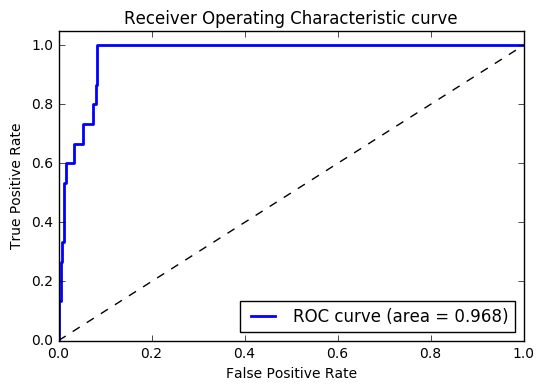

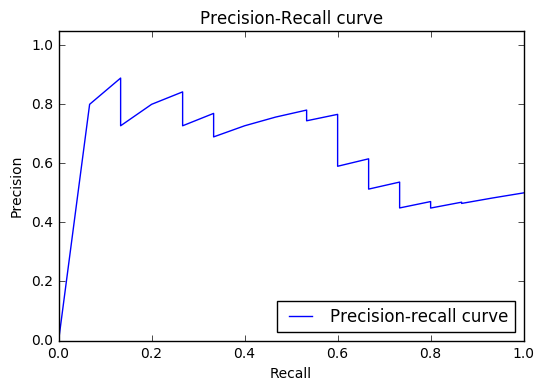

('\n', 'SVM with RBF kernel C=1000', '\ntest size is 30 %  ')
0.877333333333
precision = 0.395, recall = 1.000, F1 = 0.566, accuracy = 0.877
('The confusion matrix on the testing set:          \n',      0   1
0  643   0
1   92  15)
*********** AUC for ROC = 0.975


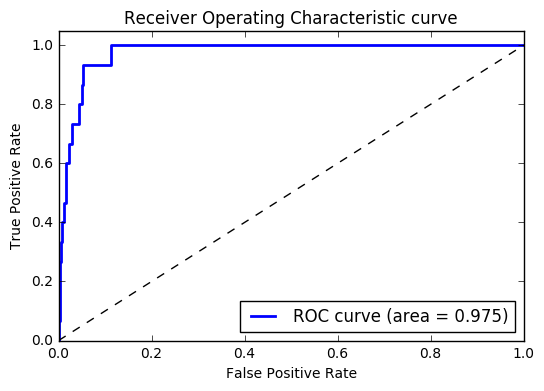

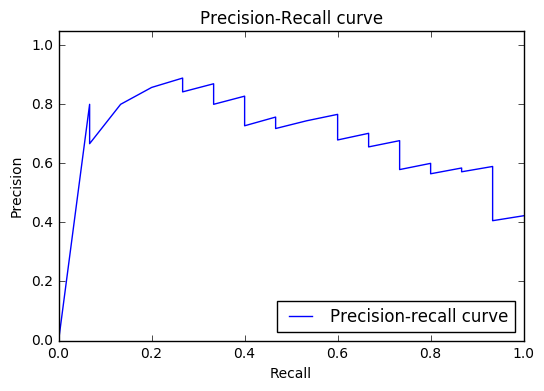

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.98
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.980
('The confusion matrix on the testing set:          \n',      0   1
0  735  15
1    0   0)
*********** AUC for ROC = 0.964


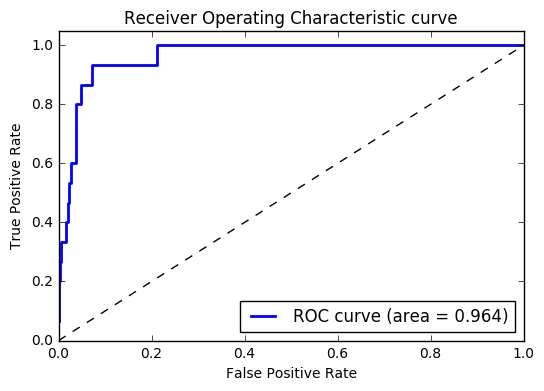

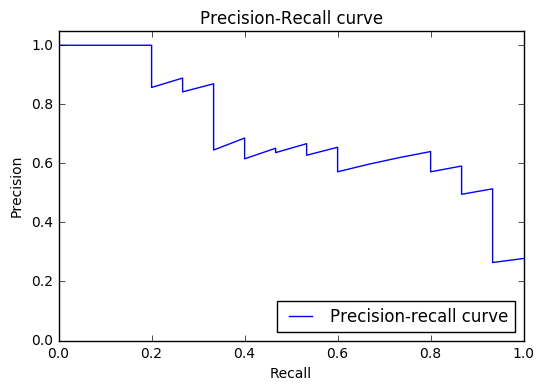

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.98
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.980
('The confusion matrix on the testing set:          \n',      0   1
0  735  15
1    0   0)
*********** AUC for ROC = 0.967


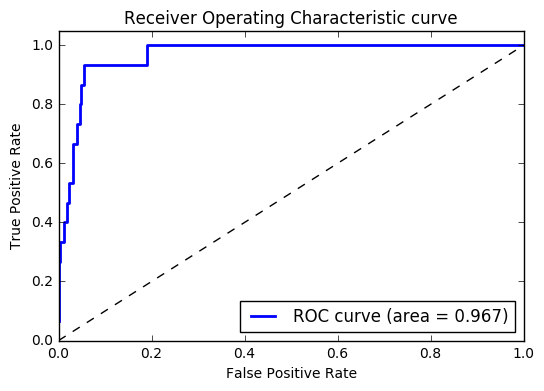

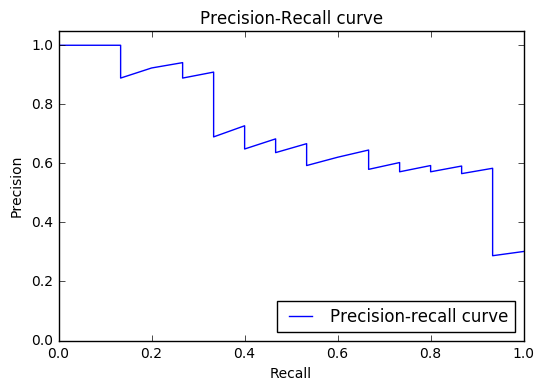

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.98
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.980
('The confusion matrix on the testing set:          \n',      0   1
0  735  15
1    0   0)
*********** AUC for ROC = 0.969


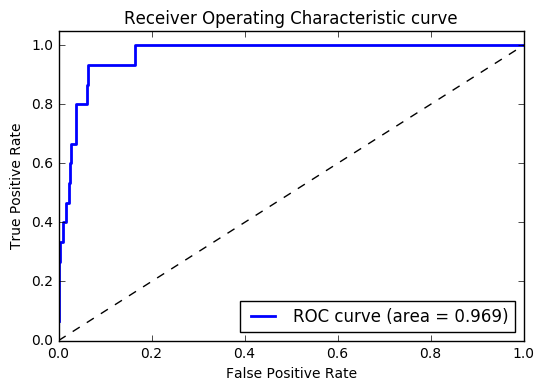

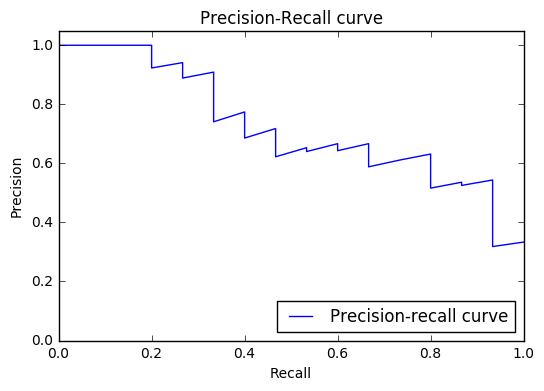

('\n', 'MLP5adaptive', '\ntest size is 30 %  ')
0.98
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.980
('The confusion matrix on the testing set:          \n',      0   1
0  735  15
1    0   0)
*********** AUC for ROC = 0.964


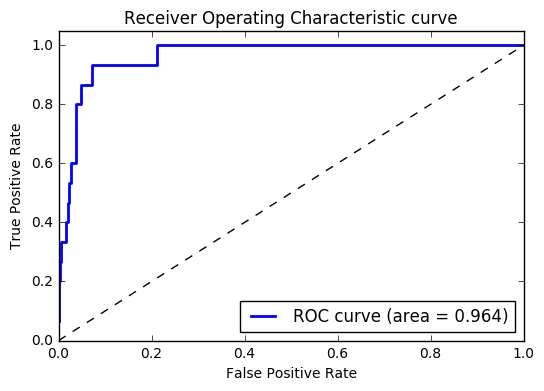

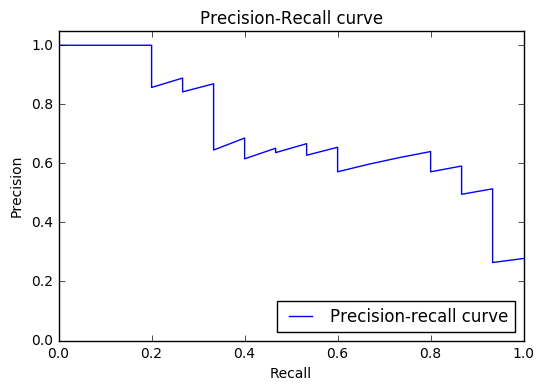

In [ ]:
##run 2
RANDOM_STATE = 61

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

Linear SVC C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=21, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.383s
test time:  0.113s
accuracy:   0.869
precision:  0.103
recall:     0.846
('Complexity: ', array([608,  11]))
*** AUC for ROC = 0.939

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.87      0.93       737
   Relevant       0.10      0.85      0.18        13

avg / total       0.98      0.87      0.92       750

confusion matrix:
[[641  96]
 [  2  11]]
()
Linear SVC C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='au

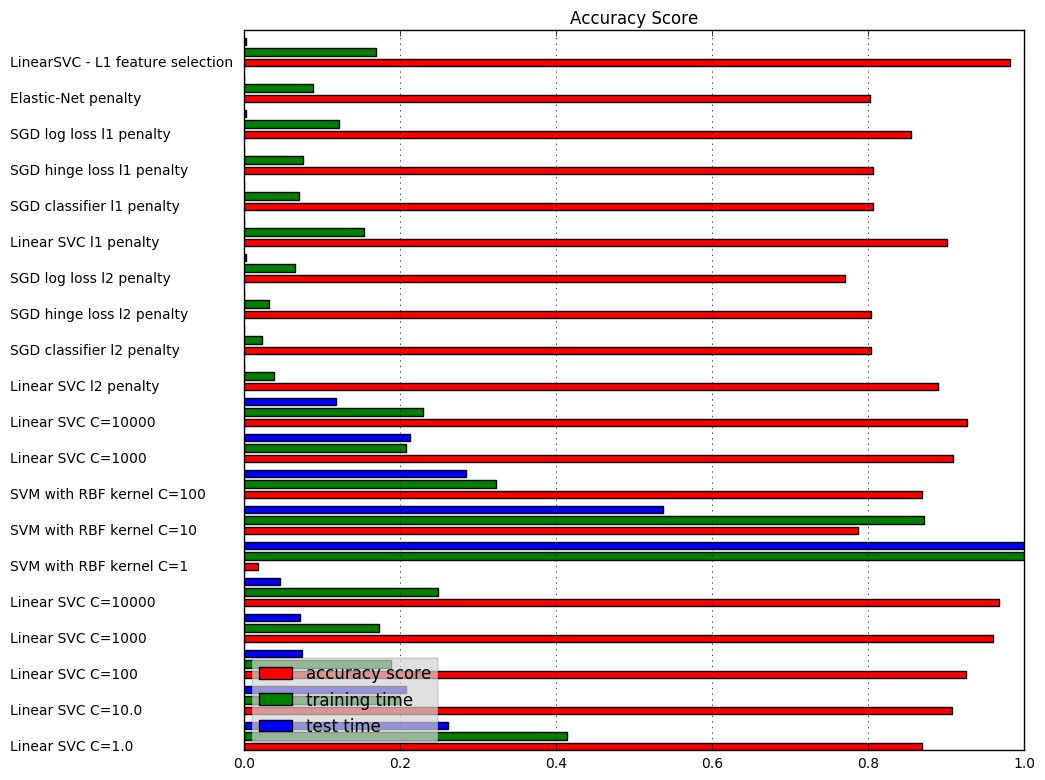

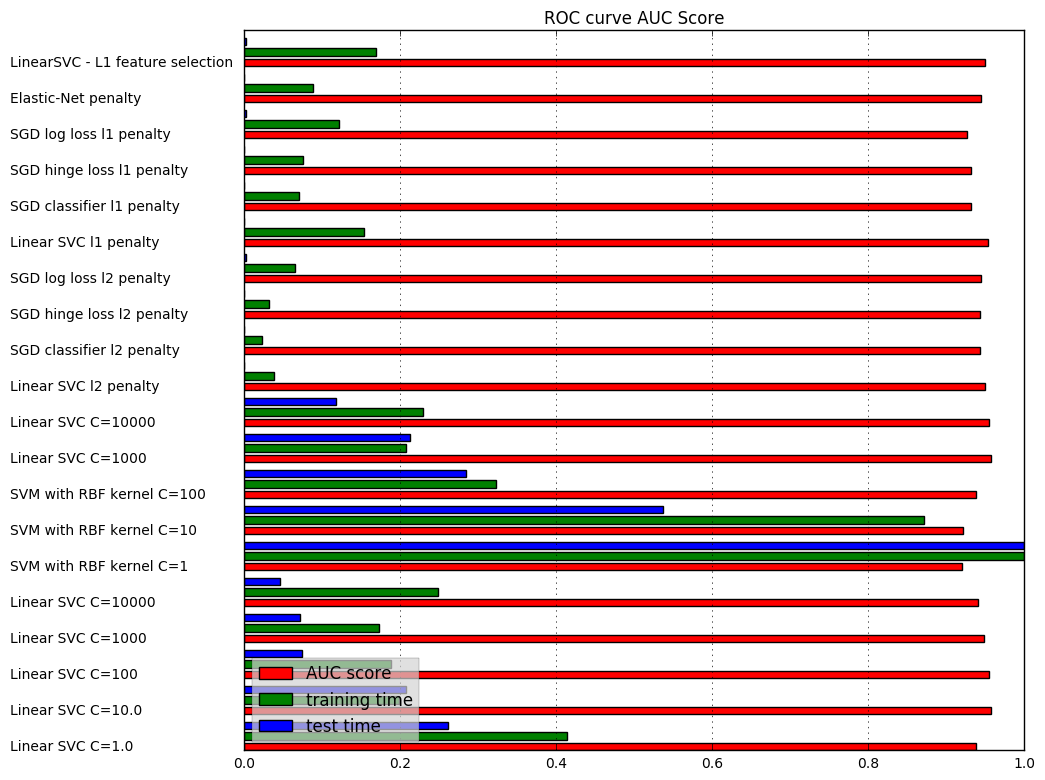

('\n', 'Perceptron50', '\ntest size is 30 %  ')
0.918666666667
precision = 0.408, recall = 0.769, F1 = 0.533, accuracy = 0.919
('The confusion matrix on the testing set:          \n',      0   1
0  679   3
1   58  10)
*********** AUC for ROC = 0.945


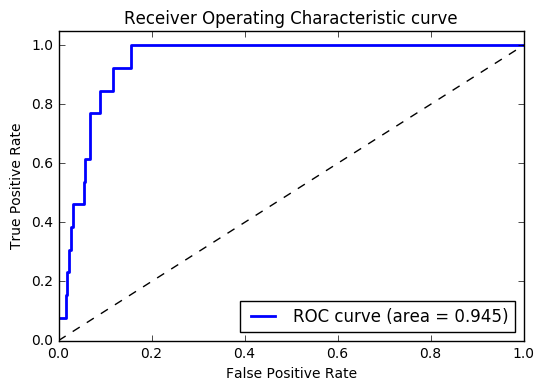

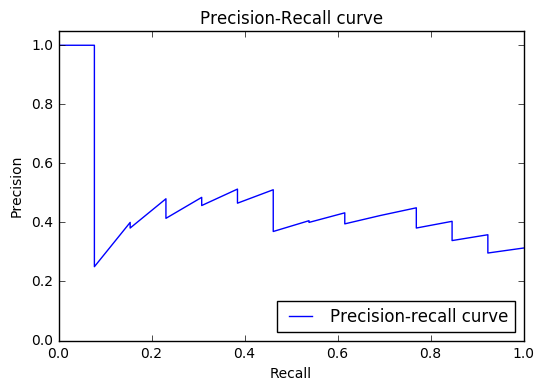

('\n', 'Perceptron50l1', '\ntest size is 30 %  ')
0.904
precision = 0.386, recall = 0.846, F1 = 0.530, accuracy = 0.904
('The confusion matrix on the testing set:          \n',      0   1
0  667   2
1   70  11)
*********** AUC for ROC = 0.944


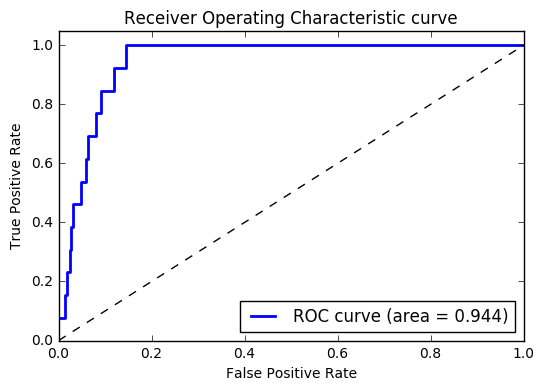

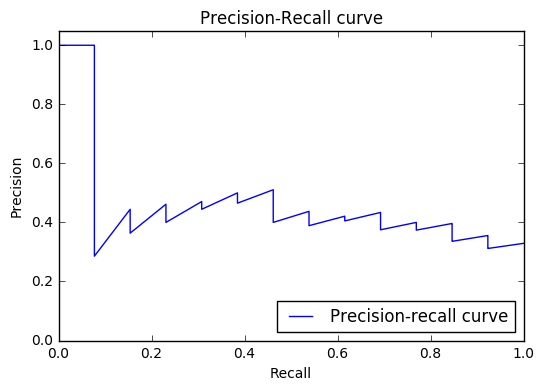

('\n', 'Perceptron50l2', '\ntest size is 30 %  ')
0.0306666666667
precision = 0.067, recall = 1.000, F1 = 0.125, accuracy = 0.031
('The confusion matrix on the testing set:          \n',      0   1
0   10   0
1  727  13)
*********** AUC for ROC = 0.927


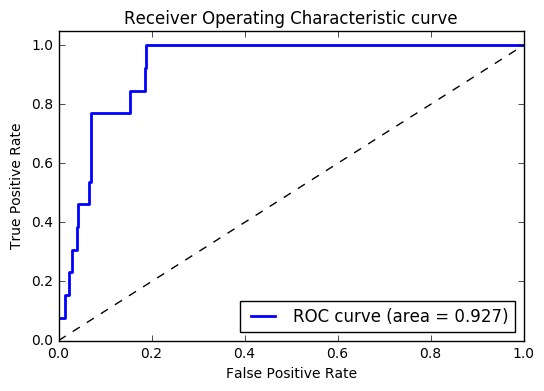

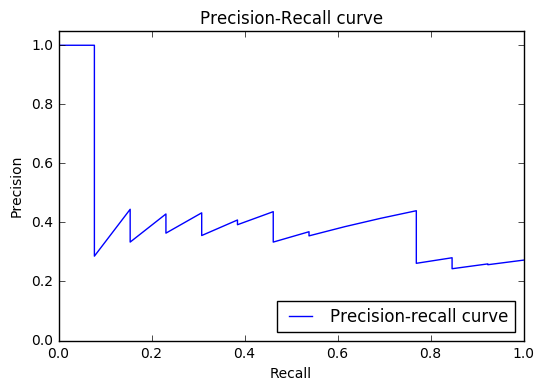

('\n', 'Perceptron20', '\ntest size is 30 %  ')
0.944
precision = 0.407, recall = 0.462, F1 = 0.432, accuracy = 0.944
('The confusion matrix on the testing set:          \n',      0  1
0  702  7
1   35  6)
*********** AUC for ROC = 0.938


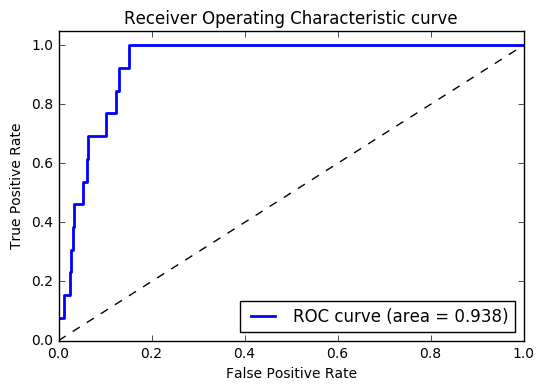

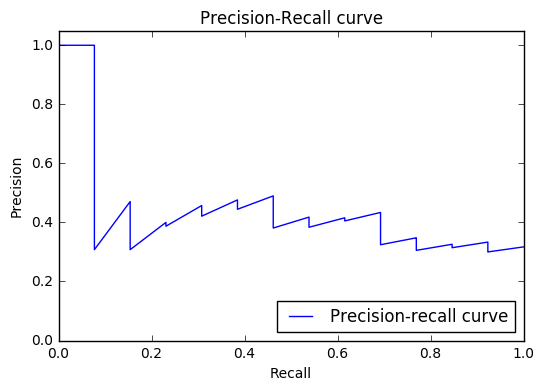

('\n', 'Perceptron20l1', '\ntest size is 30 %  ')
0.938666666667
precision = 0.381, recall = 0.462, F1 = 0.417, accuracy = 0.939
('The confusion matrix on the testing set:          \n',      0  1
0  698  7
1   39  6)
*********** AUC for ROC = 0.936


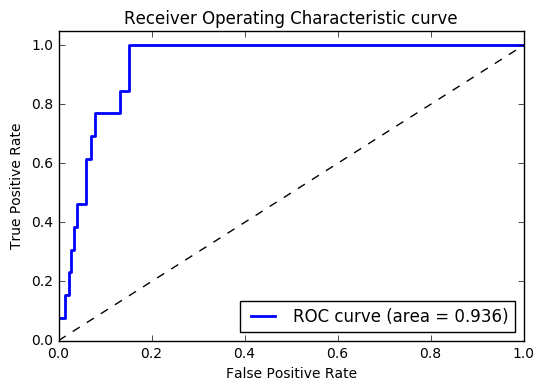

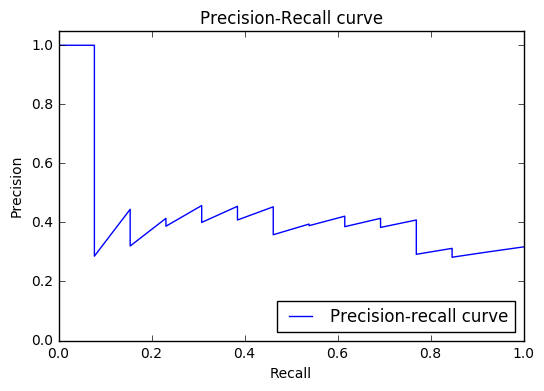

('\n', 'Perceptron20l2', '\ntest size is 30 %  ')
0.936
precision = 0.369, recall = 0.462, F1 = 0.410, accuracy = 0.936
('The confusion matrix on the testing set:          \n',      0  1
0  696  7
1   41  6)
*********** AUC for ROC = 0.930


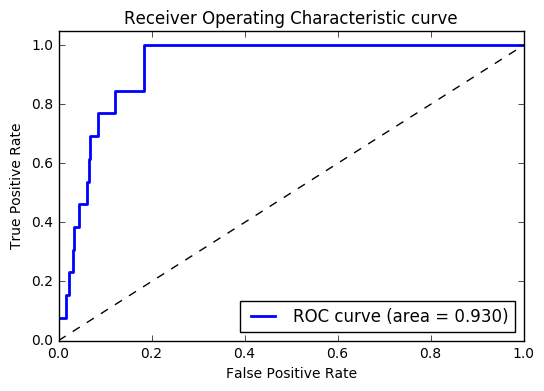

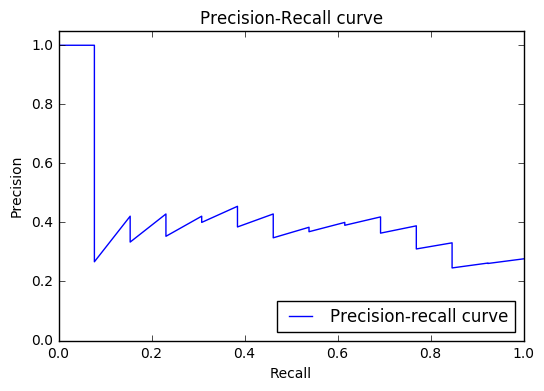

('\n', 'Logistic Regression 1e2', '\ntest size is 30 %  ')
0.918666666667
precision = 0.408, recall = 0.769, F1 = 0.533, accuracy = 0.919
('The confusion matrix on the testing set:          \n',      0   1
0  679   3
1   58  10)
*********** AUC for ROC = 0.954


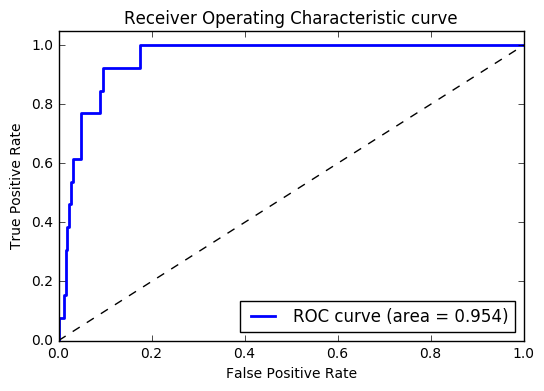

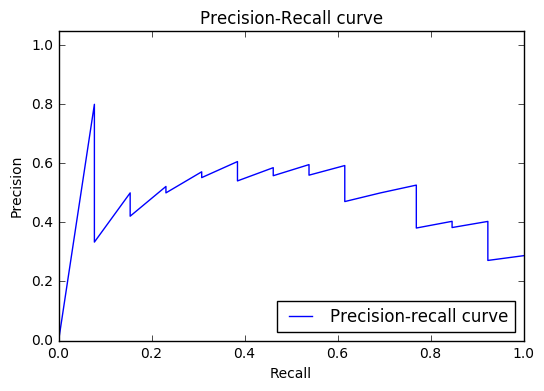

('\n', 'Logistic Regression 1e6', '\ntest size is 30 %  ')
0.976
precision = 0.686, recall = 0.462, F1 = 0.552, accuracy = 0.976
('The confusion matrix on the testing set:          \n',      0  1
0  726  7
1   11  6)
*********** AUC for ROC = 0.947


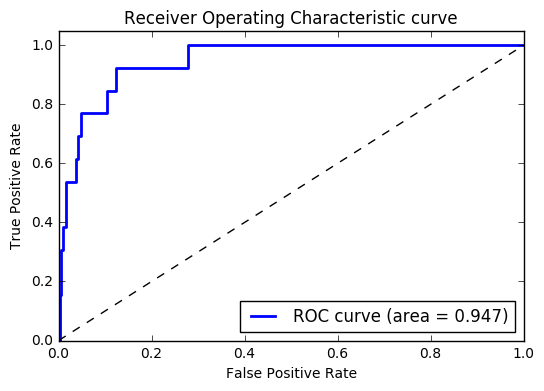

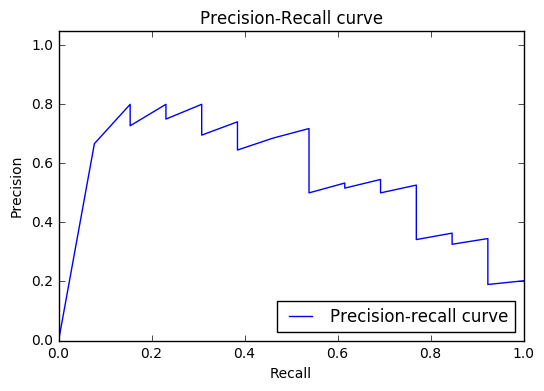

('\n', 'Linear SVC C=1.0', '\ntest size is 30 %  ')
0.873333333333
precision = 0.321, recall = 0.846, F1 = 0.466, accuracy = 0.873
('The confusion matrix on the testing set:          \n',      0   1
0  644   2
1   93  11)
*********** AUC for ROC = 0.936


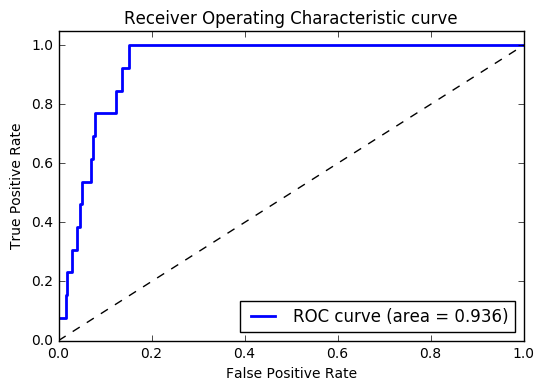

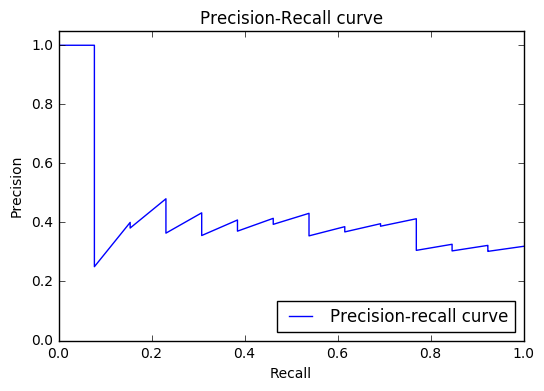

('\n', 'Linear SVC C=10.0', '\ntest size is 30 %  ')
0.906666666667
precision = 0.393, recall = 0.846, F1 = 0.537, accuracy = 0.907
('The confusion matrix on the testing set:          \n',      0   1
0  669   2
1   68  11)
*********** AUC for ROC = 0.956


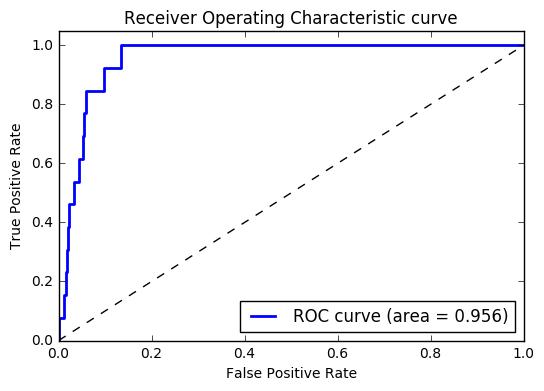

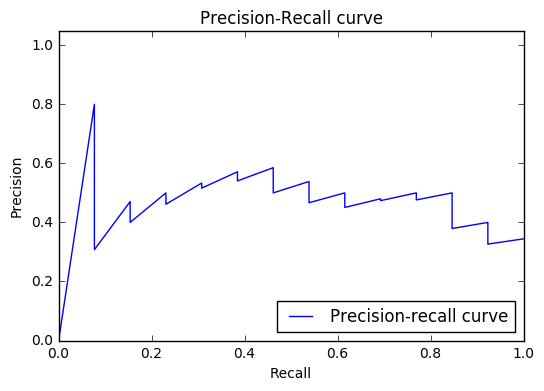

('\n', 'Linear SVC C=100.0', '\ntest size is 30 %  ')
0.928
precision = 0.440, recall = 0.769, F1 = 0.559, accuracy = 0.928
('The confusion matrix on the testing set:          \n',      0   1
0  686   3
1   51  10)
*********** AUC for ROC = 0.953


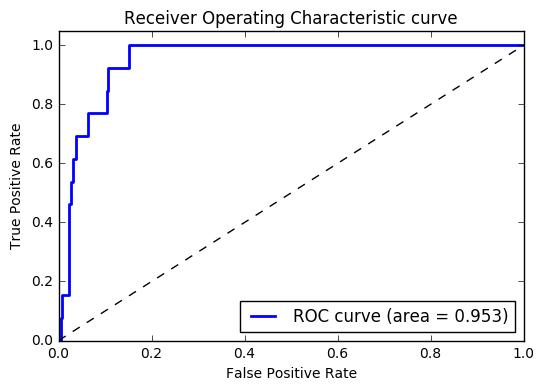

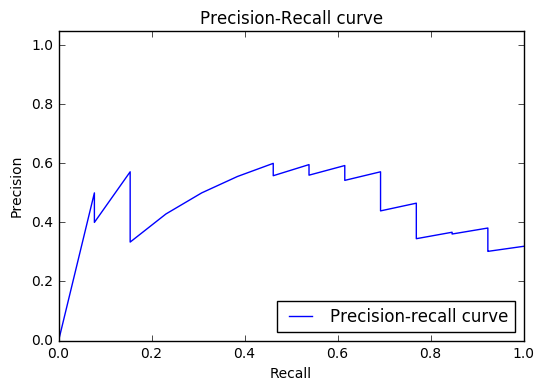

('\n', 'Linear SVC C=1000.0', '\ntest size is 30 %  ')
0.958666666667
precision = 0.552, recall = 0.615, F1 = 0.582, accuracy = 0.959
('The confusion matrix on the testing set:          \n',      0  1
0  711  5
1   26  8)
*********** AUC for ROC = 0.948


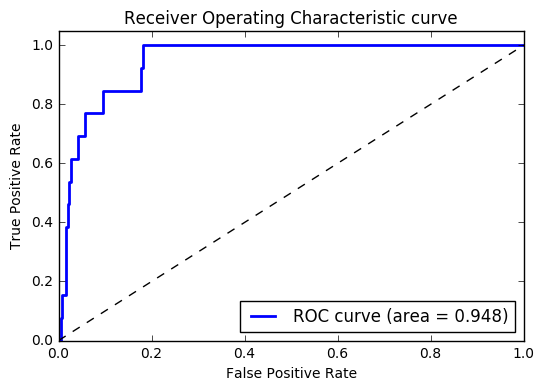

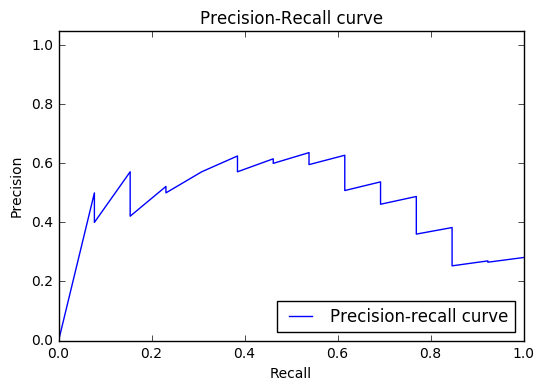

('\n', 'Linear SVC L2 penalty', '\ntest size is 30 %  ')
0.889333333333
precision = 0.352, recall = 0.846, F1 = 0.497, accuracy = 0.889
('The confusion matrix on the testing set:          \n',      0   1
0  656   2
1   81  11)
*********** AUC for ROC = 0.950


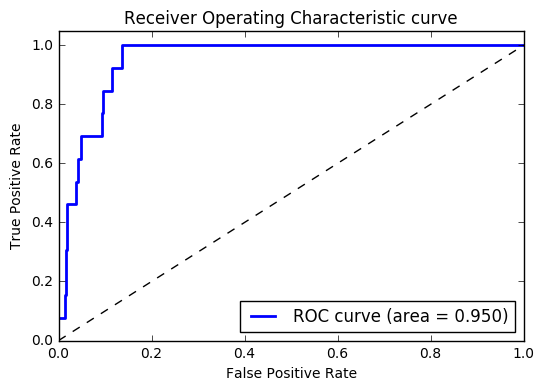

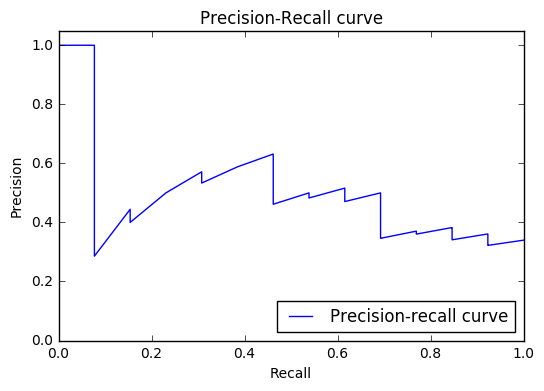

('\n', 'SVM with RBF kernel C=1', '\ntest size is 30 %  ')
0.036
precision = 0.067, recall = 1.000, F1 = 0.126, accuracy = 0.036
('The confusion matrix on the testing set:          \n',      0   1
0   14   0
1  723  13)
*********** AUC for ROC = 0.915


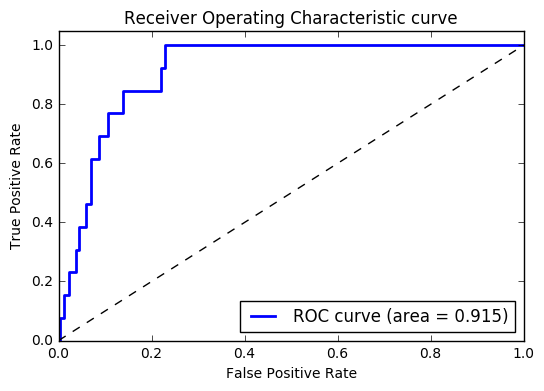

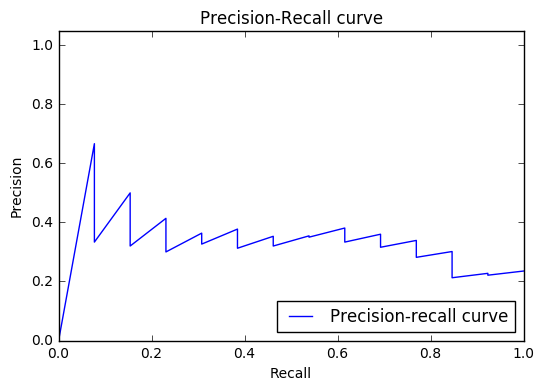

('\n', 'SVM with RBF kernel C=10', '\ntest size is 30 %  ')
0.822666666667
precision = 0.251, recall = 0.846, F1 = 0.388, accuracy = 0.823
('The confusion matrix on the testing set:          \n',      0   1
0  606   2
1  131  11)
*********** AUC for ROC = 0.918


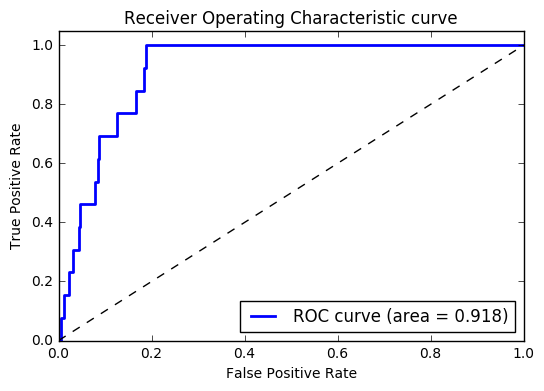

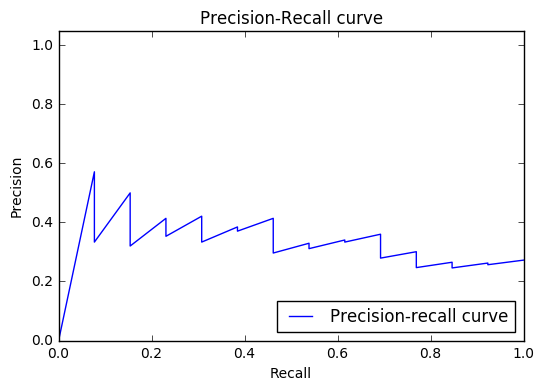

('\n', 'SVM with RBF kernel C=100', '\ntest size is 30 %  ')


In [ ]:
#run 3
RANDOM_STATE = 21

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [ ]:
#run 4
RANDOM_STATE =71

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [ ]:
#run 5
RANDOM_STATE = 35

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)